<a href="https://colab.research.google.com/github/Salma269/Stroke-Prediction-using-ML/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/ML project/stroke-dataset.csv'

# Load the dataset
# df: DataFrame
df = pd.read_csv(path)  # Replace with the correct path if needed

Mounted at /content/drive


## **1. Data Exploration and Visualization**

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

Statistics:
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000 

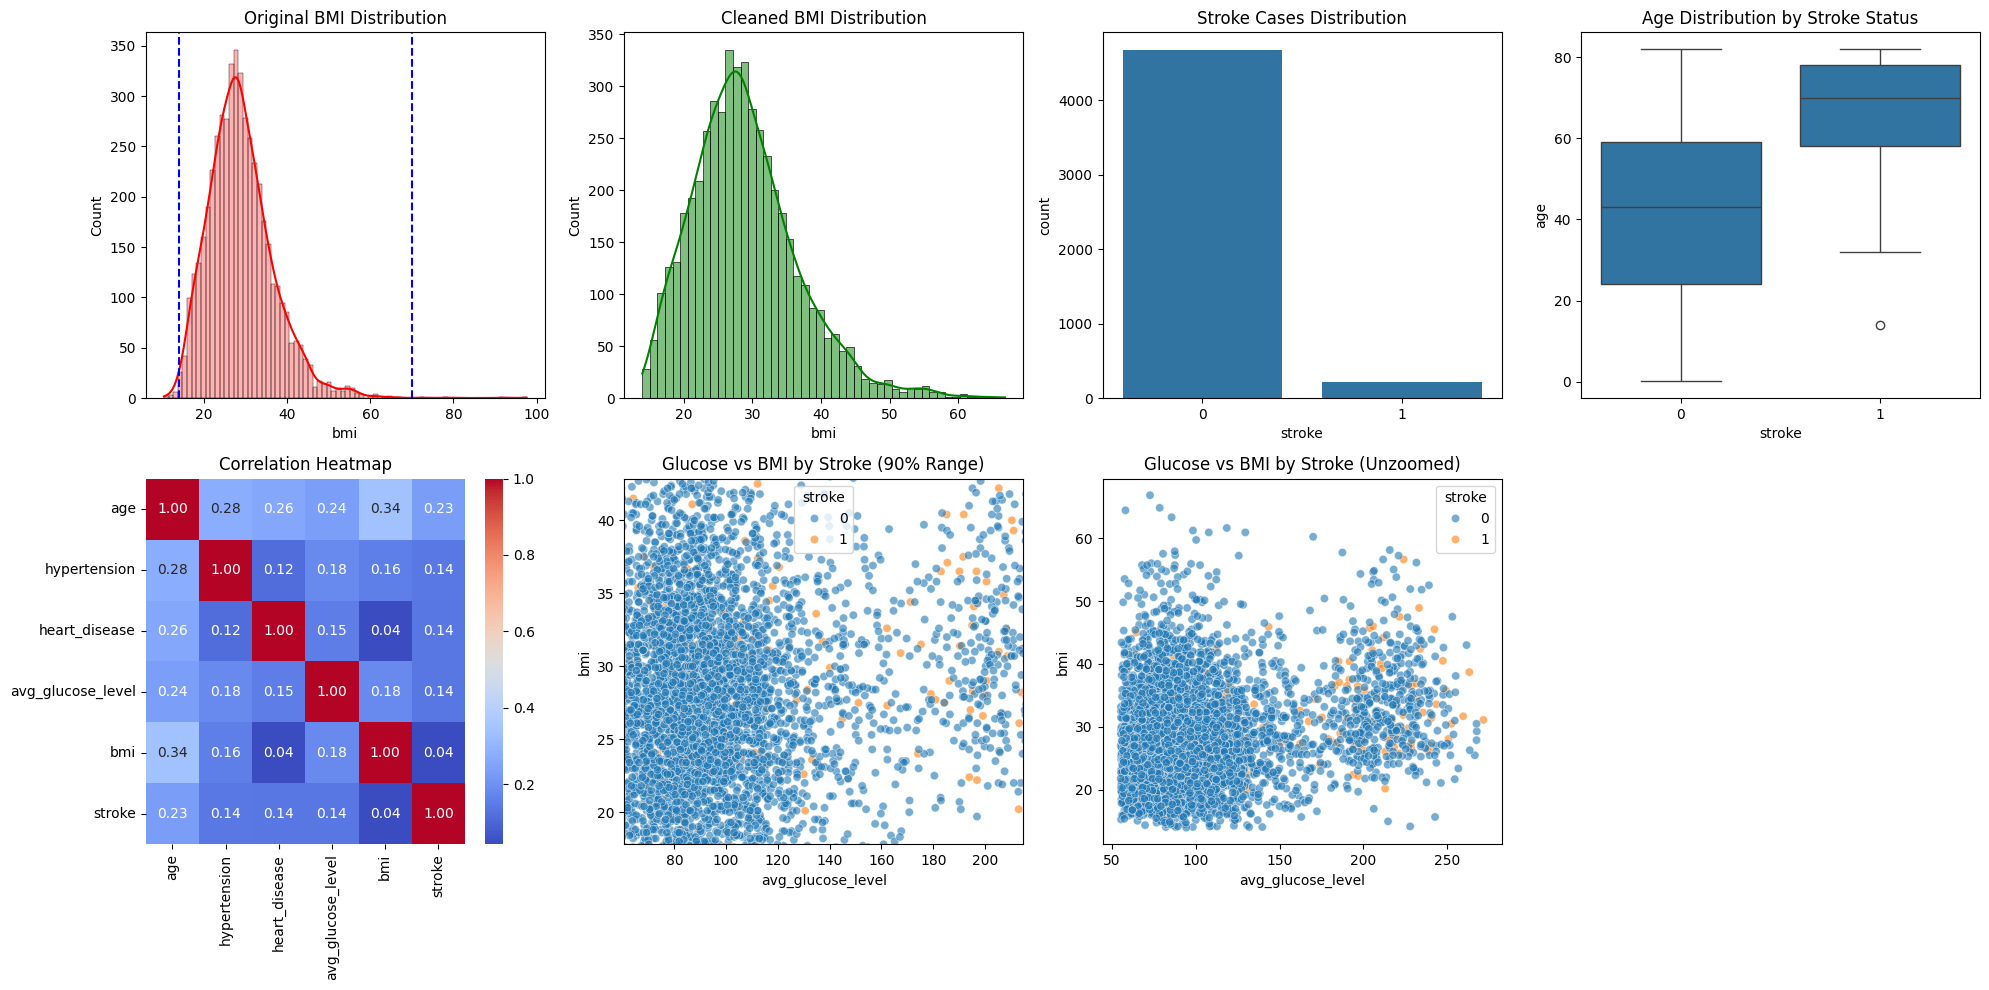

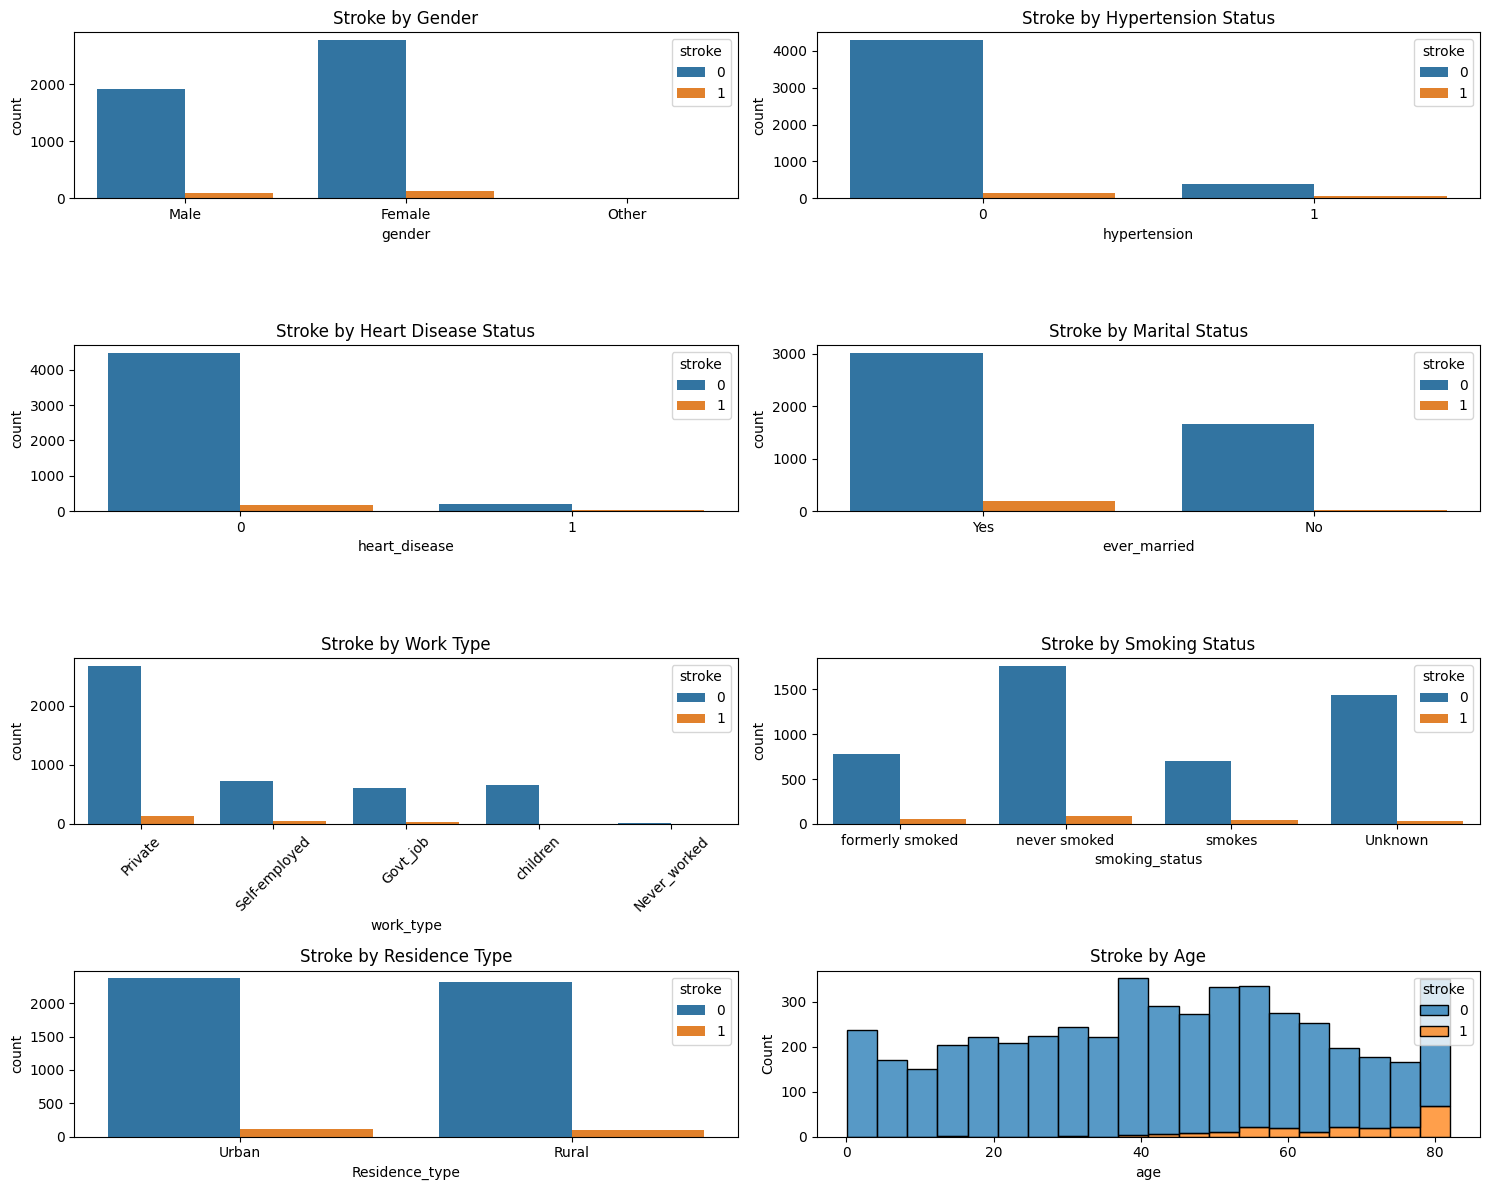

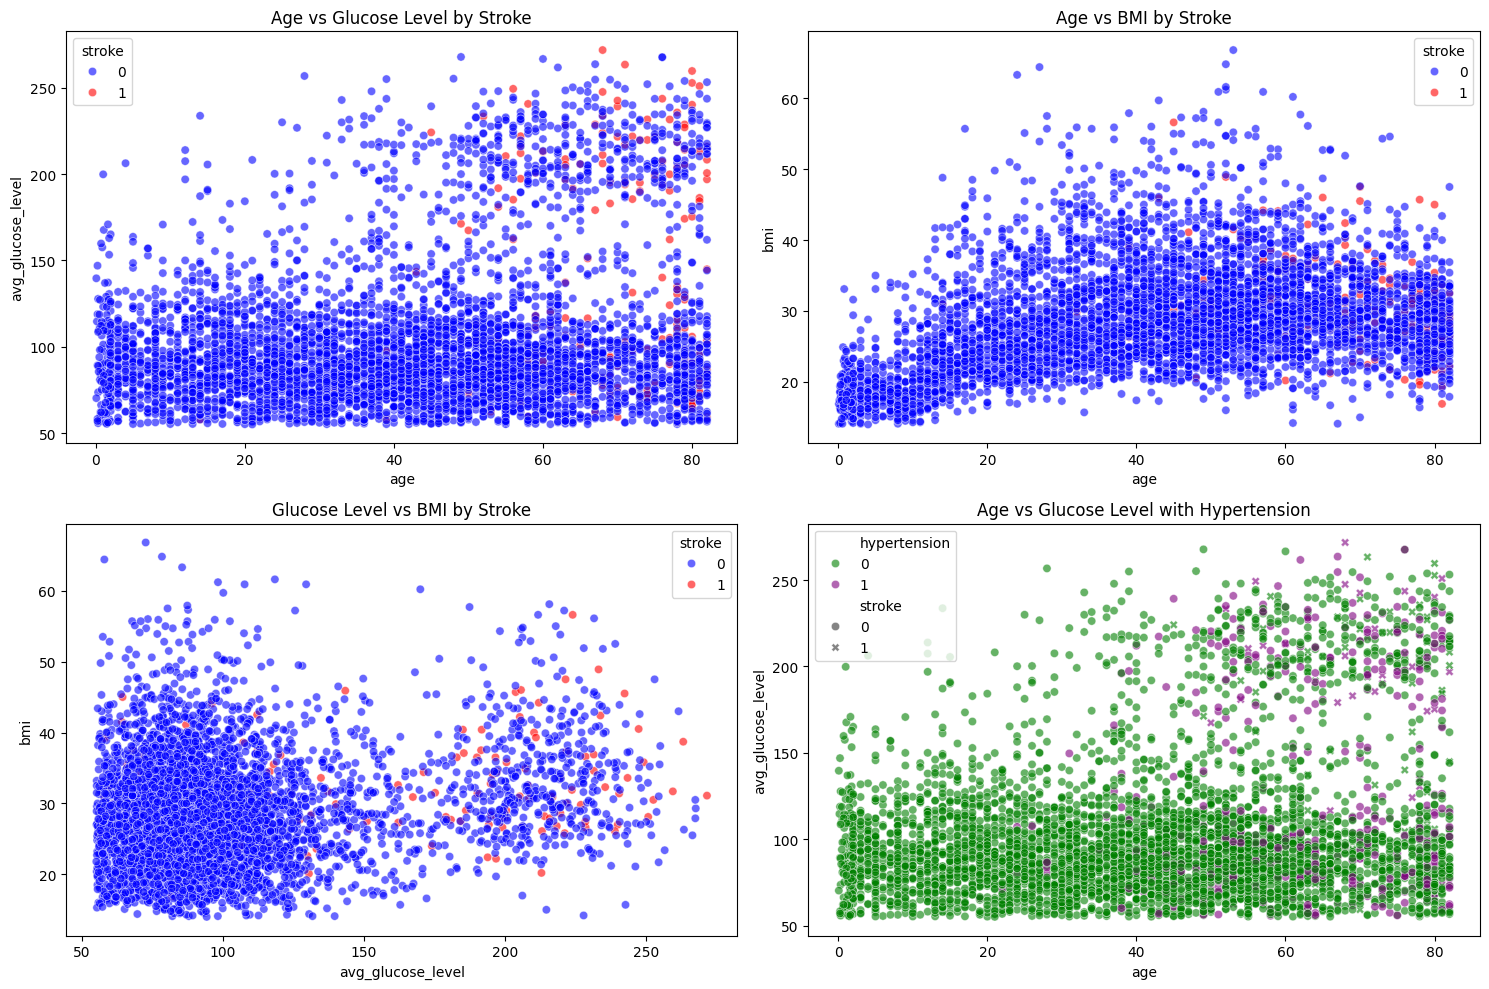

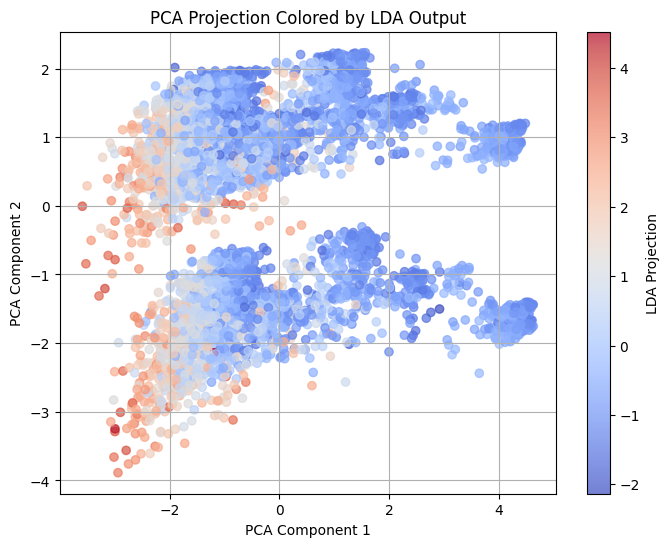

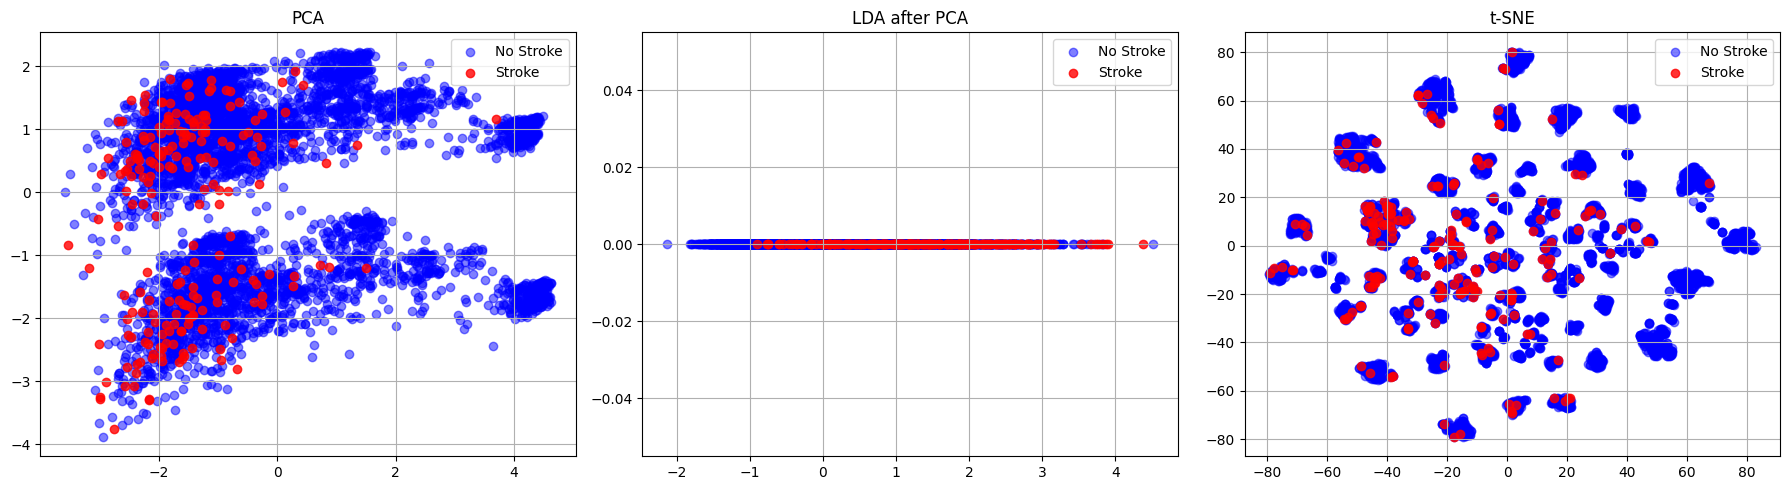


Original BMI stats:
count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

Cleaned BMI stats:
count    4889.000000
mean       28.899959
std         7.644593
min        14.000000
25%        23.600000
50%        28.100000
75%        33.100000
max        66.800000
Name: bmi, dtype: float64

PCA Explained Variance Ratio: [0.19272578 0.09942685]
Total Variance Explained by PCA: 0.29215263062924757
Number of PCA components used: 2
Number of LDA components used: 1
Number of features after encoding: 21
Number of classes: 2


In [ ]:

# Assuming df is already loaded
df_original = df.copy()

# Basic Info
print("Basic Info:")
print(df_original.info())
print("\nStatistics:")
print(df_original.describe())
print("\nMissing data:")
print(df_original.isnull().sum())
print("\nHow many people had a stroke:")
print(df_original['stroke'].value_counts())

# Unique values in categorical columns
print("\nPossible values for the text columns:")
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']
for col in categorical_cols:
    print(col, ':', df_original[col].unique())

# Data Cleaning
df_original['bmi'] = pd.to_numeric(df_original['bmi'], errors='coerce')
df_original.drop('id', axis=1, inplace=True) ###########################################################################3

# Identify and save records with extreme BMI
extreme_bmi = df_original[(df_original['bmi'] < 14) | (df_original['bmi'] > 70)]
print(f"Extreme BMI (<14 or >70): {extreme_bmi.shape[0]} records")
excluded = extreme_bmi.drop_duplicates()
print(f"Total excluded records: {excluded.shape[0]}")
excluded.to_csv('excluded_patients.csv', index=False)

# Apply filters: Keep only realistic BMI values
df_clean = df_original[
    (df_original['bmi'] >= 14) &
    (df_original['bmi'] <= 70)
].reset_index(drop=True)
print(f"\nRemaining records after filtering: {df_clean.shape[0]}")
print(f"Percentage kept: {df_clean.shape[0]/df_original.shape[0]*100:.1f}%")

# Visualizations
plt.figure(figsize=(20, 10))  # Increased width to accommodate 2x4 grid
plt.subplot(2, 4, 1)
sns.histplot(df_original['bmi'].dropna(), kde=True, color='red', alpha=0.3)
plt.axvline(14, color='blue', linestyle='--')
plt.axvline(70, color='blue', linestyle='--')
plt.title('Original BMI Distribution')

plt.subplot(2, 4, 2)
sns.histplot(df_clean['bmi'], kde=True, color='green')
plt.title('Cleaned BMI Distribution')

plt.subplot(2, 4, 3)
sns.countplot(x='stroke', data=df_clean)
plt.title('Stroke Cases Distribution')

plt.subplot(2, 4, 4)
sns.boxplot(x='stroke', y='age', data=df_clean)
plt.title('Age Distribution by Stroke Status')

plt.subplot(2, 4, 5)
numeric_df = df_clean.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')

plt.subplot(2, 4, 6)
sns.scatterplot(x='avg_glucose_level', y='bmi', hue='stroke', data=df_clean, alpha=0.6)
plt.title('Glucose vs BMI by Stroke (90% Range)')
plt.xlim(df_clean['avg_glucose_level'].quantile(0.05), df_clean['avg_glucose_level'].quantile(0.95))
plt.ylim(df_clean['bmi'].quantile(0.05), df_clean['bmi'].quantile(0.95))

plt.subplot(2, 4, 7)
sns.scatterplot(x='avg_glucose_level', y='bmi', hue='stroke', data=df_clean, alpha=0.6)
plt.title('Glucose vs BMI by Stroke (Unzoomed)')

plt.tight_layout()

# Categorical Visualizations
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
axes = axes.flatten()

sns.countplot(x='gender', hue='stroke', data=df_clean, ax=axes[0])
axes[0].set_title('Stroke by Gender')

sns.countplot(x='hypertension', hue='stroke', data=df_clean, ax=axes[1])
axes[1].set_title('Stroke by Hypertension Status')

sns.countplot(x='heart_disease', hue='stroke', data=df_clean, ax=axes[2])
axes[2].set_title('Stroke by Heart Disease Status')

sns.countplot(x='ever_married', hue='stroke', data=df_clean, ax=axes[3])
axes[3].set_title('Stroke by Marital Status')

sns.countplot(x='work_type', hue='stroke', data=df_clean, ax=axes[4])
axes[4].tick_params(axis='x', rotation=45)
axes[4].set_title('Stroke by Work Type')

sns.countplot(x='smoking_status', hue='stroke', data=df_clean, ax=axes[5])
axes[5].set_title('Stroke by Smoking Status')

sns.countplot(x='Residence_type', hue='stroke', data=df_clean, ax=axes[6])
axes[6].set_title('Stroke by Residence Type')

sns.histplot(data=df_clean, x='age', hue='stroke', multiple='stack', ax=axes[7])
axes[7].set_title('Stroke by Age')

plt.tight_layout()

# Scatter Plots for Feature Interactions
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(x='age', y='avg_glucose_level', hue='stroke', data=df_clean, alpha=0.6, palette=['blue', 'red'])
plt.title('Age vs Glucose Level by Stroke')

plt.subplot(2, 2, 2)
sns.scatterplot(x='age', y='bmi', hue='stroke', data=df_clean, alpha=0.6, palette=['blue', 'red'])
plt.title('Age vs BMI by Stroke')

plt.subplot(2, 2, 3)
sns.scatterplot(x='avg_glucose_level', y='bmi', hue='stroke', data=df_clean, alpha=0.6, palette=['blue', 'red'])
plt.title('Glucose Level vs BMI by Stroke')

plt.subplot(2, 2, 4)
sns.scatterplot(x='age', y='avg_glucose_level', hue='hypertension', style='stroke', data=df_clean, alpha=0.6, palette=['green', 'purple'])
plt.title('Age vs Glucose Level with Hypertension')

plt.tight_layout()

# Data Preparation for modeling
X = df_clean.drop(['stroke'], axis=1)
y = df_clean['stroke']
X = pd.get_dummies(X, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Fit LDA on high-dimensional data (1D for binary classification)
lda = LDA()
X_lda = lda.fit_transform(X_scaled, y)

# PCA Projection of original features (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE Projection (2D)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plotting PCA with coloring based on LDA output
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_lda.ravel(), cmap='coolwarm', alpha=0.7)
plt.title('PCA Projection Colored by LDA Output')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='LDA Projection')
plt.grid(True)
plt.show()

# Plotting PCA, LDA, t-SNE
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], alpha=0.5, label='No Stroke', c='blue')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], alpha=0.8, label='Stroke', c='red')
plt.title('PCA')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(X_lda[y==0], np.zeros_like(X_lda[y==0]), alpha=0.5, label='No Stroke', c='blue')
plt.scatter(X_lda[y==1], np.zeros_like(X_lda[y==1]), alpha=0.8, label='Stroke', c='red')
plt.title('LDA after PCA')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], alpha=0.5, label='No Stroke', c='blue')
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], alpha=0.8, label='Stroke', c='red')
plt.title('t-SNE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Summary
print("\nOriginal BMI stats:")
print(df_original['bmi'].describe())
print("\nCleaned BMI stats:")
print(df_clean['bmi'].describe())
print("\nPCA Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Variance Explained by PCA:", sum(pca.explained_variance_ratio_))
print(f"Number of PCA components used: {X_pca.shape[1]}")
print(f"Number of LDA components used: {X_lda.shape[1]}")
print(f"Number of features after encoding: {X_scaled.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

##2.Data Cleaning and Preprocessing

In [ ]:
# Check duplicates
duplicate_count = df_clean.duplicated().sum()
duplicates = df_clean[df_clean.duplicated(keep=False)]

# Print results
print(f"Total rows after cleaning: {len(df_clean)}")
print(f"Duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    print("\nDuplicate rows details:")
    print(duplicates)

Total rows after cleaning: 4889
Duplicate rows: 0


In [ ]:
# Check for age <= 0
invalid_age = df_clean[df_clean['age'] <= 0]
invalid_age_count = len(invalid_age)
print(f"Rows with age <= 0: {invalid_age_count}")

Rows with age <= 0: 0


In [ ]:
#checking that everyone under 18 has work type = childern
# Filter work_type = 'children'
children_work_type = df_clean[df_clean['work_type'] == 'children'].copy()
children_work_type_count = len(children_work_type)

# Check if all are children (age < 18)
non_children = children_work_type[children_work_type['age'] >= 18]
non_children_count = len(non_children)
actual_children_count = children_work_type_count - non_children_count

# Print results
print(f"Total individuals with work_type = 'children': {children_work_type_count}")
print(f"Actual children (age < 18): {actual_children_count}")

Total individuals with work_type = 'children': 657
Actual children (age < 18): 657


In [ ]:
# Filter children
children = df_clean[df_clean['age'] < 18].copy()
children_count = len(children)

 # Count work_type and ever_married
work_type_counts = children['work_type'].value_counts()
ever_married_counts = children['ever_married'].value_counts()

# Print results
print(f"Total children (age < 18): {children_count}")
print("\nWork Type for Children:")
print(work_type_counts)
print("\nEver Married for Children:")
print(ever_married_counts)


Total children (age < 18): 821

Work Type for Children:
work_type
children         657
Private          129
Never_worked      17
Self-employed     12
Govt_job           6
Name: count, dtype: int64

Ever Married for Children:
ever_married
No    821
Name: count, dtype: int64


In [ ]:
#For children under 2 years old BMI is not used.
children_two_and_under = len(df_clean[df_clean['age'] < 2])
print(f"Children aged 2 and under (age < 2): {children_two_and_under}")

Children aged 2 and under (age < 2): 108


In [ ]:
# REMOVE children under age 2
df = df_clean[df_clean['age'] >= 2]
children_two_and_under = df[df['age'] < 2]
under_2_count_after = len(children_two_and_under)
print(f"Children aged 2 and under after removal (age < 2): {under_2_count_after}")

Children aged 2 and under after removal (age < 2): 0


In [ ]:
# REMOVE children (age < 18) with work_type = 'Govt_job'
df = df[~((df['age'] < 18) & (df['work_type'] == 'Govt_job'))]
children = df[df['age'] < 18].copy()
govt_job_children = children[children['work_type'] == 'Govt_job']
print(f"Children with work_type = 'Govt_job': {len(govt_job_children)}")

Children with work_type = 'Govt_job': 0


In [ ]:
##handling missing and incorrect values

# Remove 'id' as it's not useful
#df.drop('id', axis=1, inplace=True)

# fixing missing BMI
df['bmi'].fillna(df['bmi'].median(), inplace=True) # median not mean because Mean is heavily influenced by outliers
# however, for this dataset the mean is 28.9 and the median is 28.1 so it doesn't matter which one to use

# Fix 'gender' unknowns as it is a rare value
df = df[df['gender'] != 'Other']

# Fixing incorrect values
df = df[df['bmi'] > 0]

In [ ]:
# REMOVE 'Unknown' smoking_status for children
unknown_count = len(df[df['smoking_status'] == 'Unknown'])
print(f"Total people with smoking_status = 'Unknown': {unknown_count}")

children = df[df['age'] < 18]
unknown_count = len(children[children['smoking_status'] == 'Unknown'])
df.loc[(df['age'] < 18) & (df['smoking_status'] == 'Unknown'), 'smoking_status'] = 'never smoked'

# Verify imputation
children_after = df[df['age'] < 18]
unknown_after = len(children_after[children_after['smoking_status'] == 'Unknown'])

# Print results
print(f"Total Children (age < 18): {len(children)}")
print(f"Unknown smoking status for childern before: {unknown_count}")
print(f"Unknown smoking status for childern after: {unknown_after}")


Total people with smoking_status = 'Unknown': 1357
Total Children (age < 18): 707
Unknown smoking status for childern before: 541
Unknown smoking status for childern after: 0


In [ ]:
# Shows what possible values each text column has
print("Possible values for the text columns:")
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']
for col in categorical_cols:
    print(col,':',df[col].unique())

Possible values for the text columns:
gender : ['Male' 'Female']
hypertension : [0 1]
heart_disease : [1 0]
ever_married : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke : [1 0]


In [ ]:
# Label encode binary columns
label_enc = LabelEncoder()
df['gender'] = label_enc.fit_transform(df['gender'])
df['ever_married'] = label_enc.fit_transform(df['ever_married'])
df['Residence_type'] = label_enc.fit_transform(df['Residence_type'])

# One-hot encode multi-class columns
df['original_work_type'] = df['work_type']
df['original_smoking_status'] = df['smoking_status']
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], drop_first=True)


In [ ]:
df = df.drop(['original_work_type', 'original_smoking_status'], axis=1)


In [ ]:
from imblearn.over_sampling import SMOTE

# 1. Separate features and target
X = df.drop(['stroke'], axis=1)
y = df['stroke']

# 3. Store column names before any transformations
original_columns = X.columns

# 4. Impute missing values (especially in bmi column)
print("Missing values before imputation:")
print(X.isna().sum())

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=original_columns)

print("\nMissing values after imputation:")
print(X_imputed.isna().sum())

# 5. Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
X_imputed[numerical_cols] = scaler.fit_transform(X_imputed[numerical_cols])

# 6. Apply SMOTE
print("\nOriginal class distribution:")
print(y.value_counts())

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_imputed, y)

print("\nResampled class distribution:")
print(pd.Series(y_resampled).value_counts())

# 7. Save processed data
resampled_df = pd.DataFrame(X_resampled, columns=original_columns)
resampled_df['stroke'] = y_resampled
resampled_df.to_csv('stroke_data_processed_resampled.csv', index=False)

print("\nProcessing complete! Saved to 'stroke_data_processed_resampled.csv'")

Missing values before imputation:
gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

Missing values after imputation:
gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-empl

Text(0.5, 1.0, 'Stroke Cases Distribution')

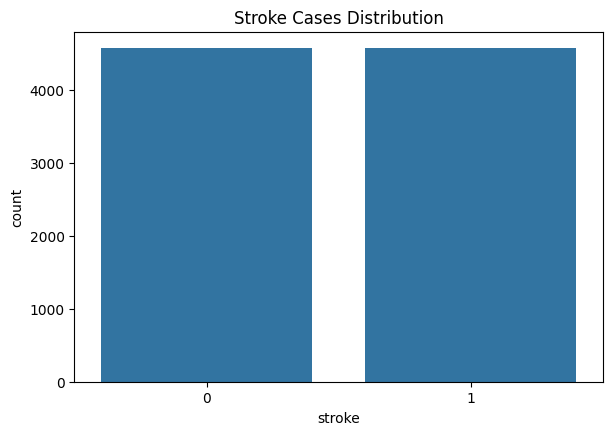

In [ ]:
# Visualizations (Simplified)
plt.figure(figsize=(15, 10))

# 1. Stroke Distribution
plt.subplot(2, 2, 1)
sns.countplot(x='stroke', data=resampled_df)
plt.title('Stroke Cases Distribution')

In [ ]:
# Split data
X = resampled_df.drop('stroke', axis=1)
y = resampled_df['stroke']
# First split: 85% (train+val) and 15% (test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=767, random_state=42, stratify=y)
# Second split: 82.35% of temp (70% of total) for train, 17.65% of temp (15% of total) for val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=766, random_state=42, stratify=y_temp)

# Print split sizes
print(f"Training set: {len(X_train)} rows")
print(f"Validation set: {len(X_val)} rows")
print(f"Testing set: {len(X_test)} rows")

# Combine X and y for saving
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

Training set: 7597 rows
Validation set: 766 rows
Testing set: 767 rows


## 3.Training and Testing Classifiers

In [ ]:
!pip install optuna

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


### Naïve Bayes Classifier

In [ ]:
# === Naïve Bayes Classifier ===
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Validation
val_preds_nb = nb_model.predict(X_val)
print("=== Naïve Bayes Validation Accuracy:", accuracy_score(y_val, val_preds_nb))

# Final test
nb_preds = nb_model.predict(X_test)
print("\n=== Naïve Bayes Test Results ===")
print("Accuracy:", accuracy_score(y_test, nb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, nb_preds))
print("Classification Report:\n", classification_report(y_test, nb_preds))


=== Naïve Bayes Validation Accuracy: 0.6501305483028721

=== Naïve Bayes Test Results ===
Accuracy: 0.6466753585397653
Confusion Matrix:
 [[117 267]
 [  4 379]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.30      0.46       384
           1       0.59      0.99      0.74       383

    accuracy                           0.65       767
   macro avg       0.78      0.65      0.60       767
weighted avg       0.78      0.65      0.60       767




=== Naïve Bayes Test Results ===
Accuracy: 0.6466753585397653


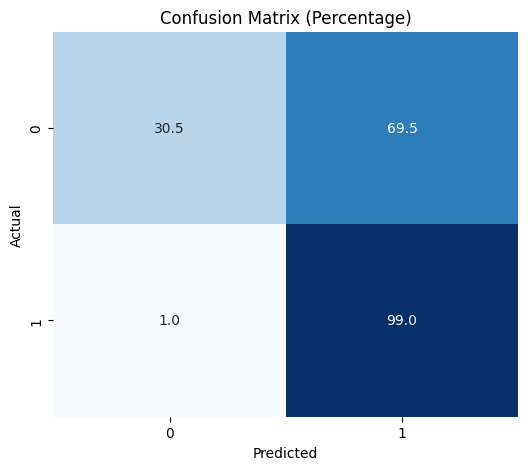

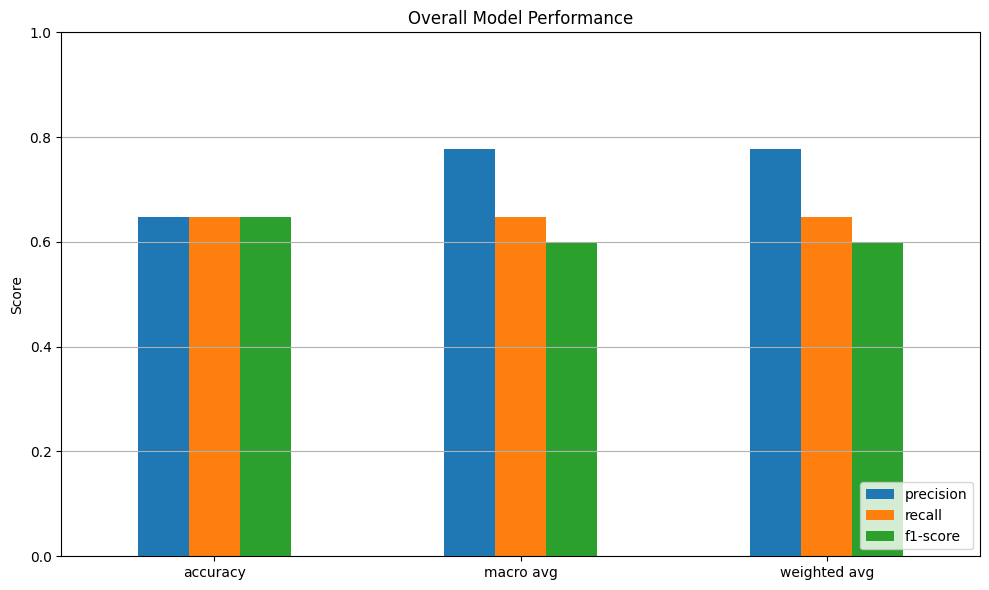

In [ ]:
# Predict using the Naïve Bayes model
nb_preds = nb_model.predict(X_test)

# Accuracy
print("\n=== Naïve Bayes Test Results ===")
print("Accuracy:", accuracy_score(y_test, nb_preds))

# Confusion Matrix (percentages)
cm = confusion_matrix(y_test, nb_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Get classification report as dict
report_dict = classification_report(y_test, nb_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Drop support column if it exists
report_df = report_df.drop(columns="support", errors='ignore')

# Keep only overall metrics
overall_rows = ["accuracy", "macro avg", "weighted avg"]
report_df_filtered = report_df.loc[overall_rows]

# Plot as bar chart
report_df_filtered.plot(kind='bar', figsize=(10, 6))
plt.title("Overall Model Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
# Tune Hyperparameters Naïve Bayes Using GridSearch

params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}

grid = GridSearchCV(GaussianNB(), params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best var_smoothing:", grid.best_params_)
print("Best accuracy:", grid.best_score_)


Best var_smoothing: {'var_smoothing': 0.01}
Best accuracy: 0.7577977201067184


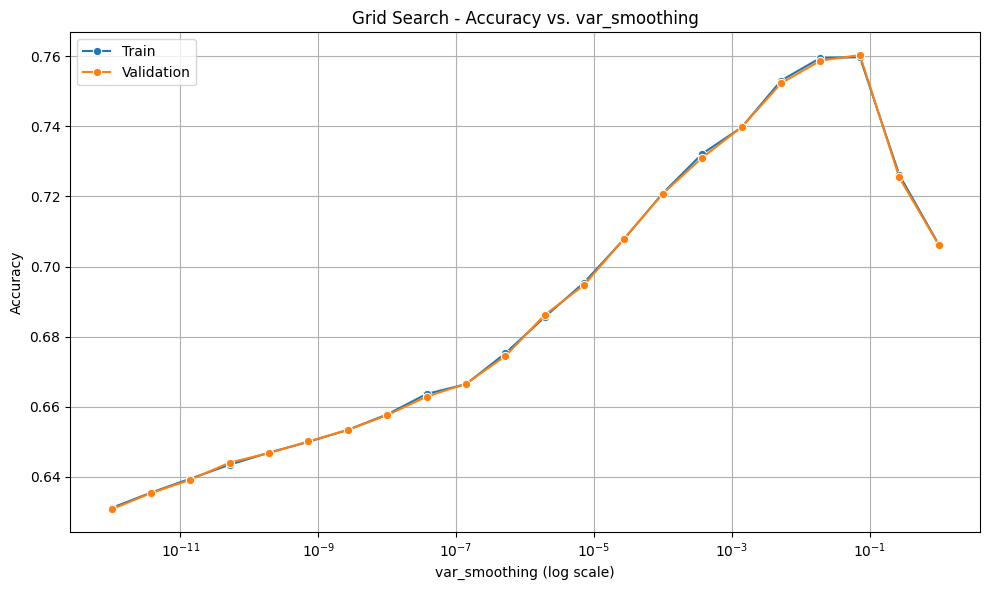

In [ ]:
# Define parameter grid
param_grid = {
    'var_smoothing': np.logspace(-12, 0, 22)
}

# Fit GridSearchCV (with return_train_score=True!)
grid = GridSearchCV(
    GaussianNB(),
    param_grid,
    cv=5,
    return_train_score=True
)
grid.fit(X_train, y_train)

# Convert results to DataFrame
grid_results = pd.DataFrame(grid.cv_results_)

# Convert to float just to be safe
grid_results["param_var_smoothing"] = grid_results["param_var_smoothing"].astype(float)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grid_results, x="param_var_smoothing", y="mean_train_score", label="Train", marker="o")
sns.lineplot(data=grid_results, x="param_var_smoothing", y="mean_test_score", label="Validation", marker="o")
plt.title("Grid Search - Accuracy vs. var_smoothing")
plt.xlabel("var_smoothing (log scale)")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Tune Hyperparameters Naïve Bayes Using optuna
def objective(trial):
    # Suggest var_smoothing on a log scale
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-12, 1)

    model = GaussianNB(var_smoothing=var_smoothing)

    # Use cross-validation to evaluate performance
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    return scores.mean()

# Create study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Print results
print("Best parameters (Optuna):", study.best_params)
print("Best accuracy:", study.best_value)

# Train final model with best params
best_model = GaussianNB(var_smoothing=study.best_params['var_smoothing'])
best_model.fit(X_train, y_train)


[I 2025-05-13 14:36:50,487] A new study created in memory with name: no-name-26fbc39f-e544-4c5a-940c-72ee2c5b956c
[I 2025-05-13 14:36:50,556] Trial 0 finished with value: 0.6501249090468105 and parameters: {'var_smoothing': 7.000741557633438e-10}. Best is trial 0 with value: 0.6501249090468105.
[I 2025-05-13 14:36:50,616] Trial 1 finished with value: 0.6403850351685666 and parameters: {'var_smoothing': 1.8206287086781767e-11}. Best is trial 0 with value: 0.6501249090468105.
[I 2025-05-13 14:36:50,680] Trial 2 finished with value: 0.6403850351685666 and parameters: {'var_smoothing': 1.767468513765093e-11}. Best is trial 0 with value: 0.6501249090468105.
[I 2025-05-13 14:36:50,741] Trial 3 finished with value: 0.6498616645299886 and parameters: {'var_smoothing': 6.296828203846041e-10}. Best is trial 0 with value: 0.6501249090468105.
[I 2025-05-13 14:36:50,802] Trial 4 finished with value: 0.7235722947922801 and parameters: {'var_smoothing': 0.29722533850259497}. Best is trial 4 with valu

Best parameters (Optuna): {'var_smoothing': 0.06819549041934805}
Best accuracy: 0.7600362080315997


GaussianNB(var_smoothing=0.06819549041934805)

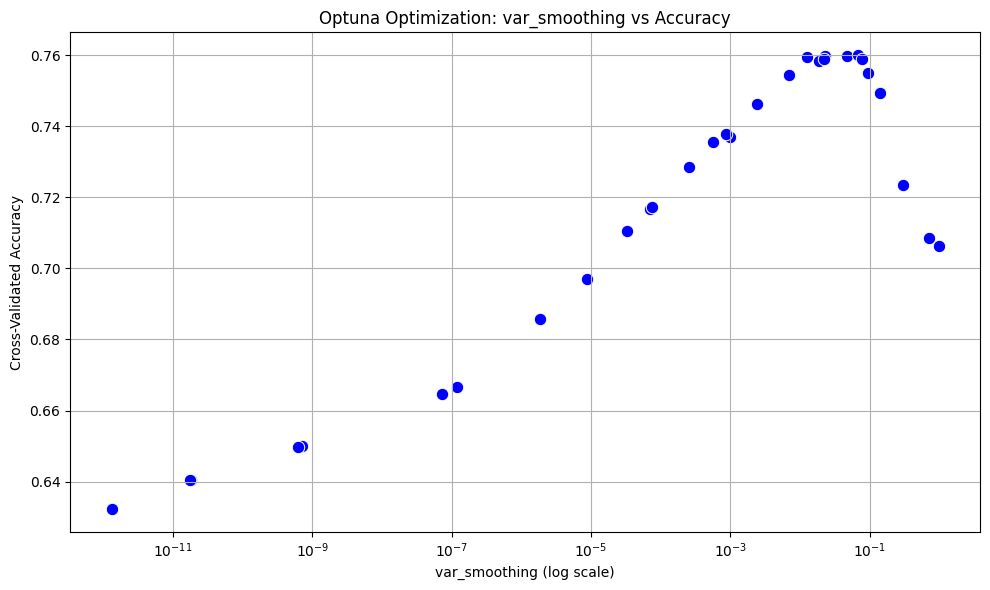

In [ ]:

# Extract trial data
var_smoothing_vals = []
accuracies = []

for trial in study.trials:
    if trial.value is not None:
        var_smoothing_vals.append(trial.params['var_smoothing'])
        accuracies.append(trial.value)

# Create DataFrame
optuna_df = pd.DataFrame({
    'var_smoothing': var_smoothing_vals,
    'accuracy': accuracies
})

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=optuna_df, x='var_smoothing', y='accuracy', s=80, color='blue')
plt.xscale('log')
plt.xlabel('var_smoothing (log scale)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optuna Optimization: var_smoothing vs Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()



=== Naïve Bayes Test Results ===
Accuracy: 0.7796610169491526


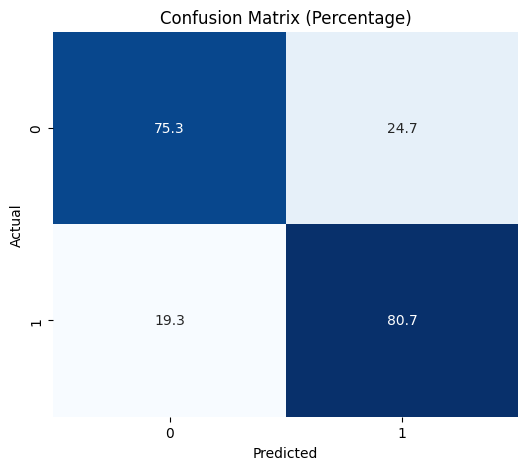

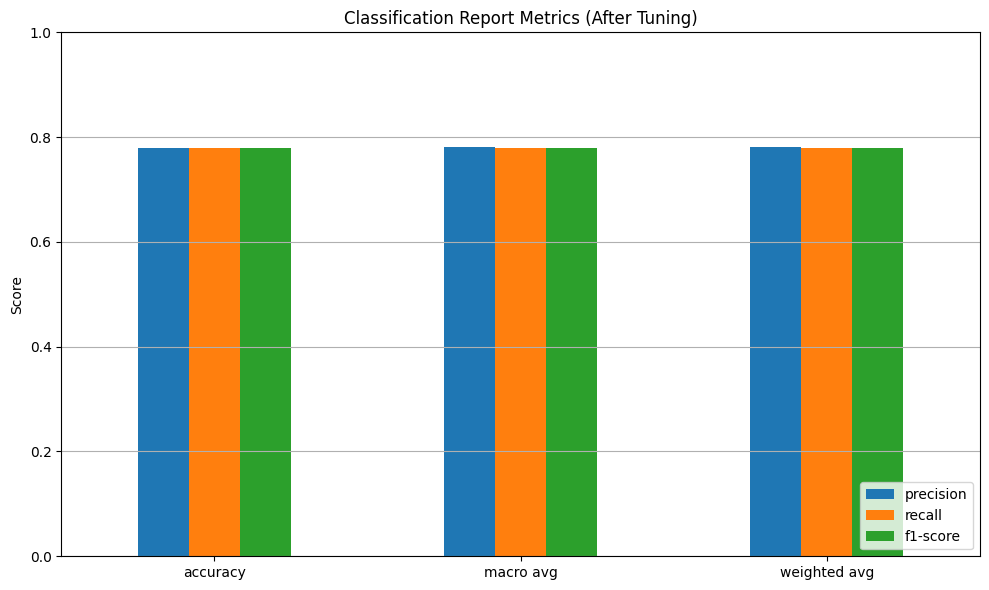

In [ ]:
# Step 1: Use best_model from Optuna
# (Assumes you've already run Optuna and trained best_model)

# Step 2: Predict using the tuned Naïve Bayes model
nb_preds = best_model.predict(X_test)

# Step 3: Accuracy
print("\n=== Naïve Bayes Test Results ===")
print("Accuracy:", accuracy_score(y_test, nb_preds))

# Step 4: Confusion Matrix (percentages)
cm = confusion_matrix(y_test, nb_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 5: Classification Report as Histogram
report_dict = classification_report(y_test, nb_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Remove support column
report_df = report_df.drop(columns="support", errors='ignore')

# Only plot class rows (not avg/total)
# Keep only overall metrics
overall_rows = ["accuracy", "macro avg", "weighted avg"]
report_df_filtered = report_df.loc[overall_rows]

report_df_filtered.plot(kind='bar', figsize=(10, 6))
plt.title("Classification Report Metrics (After Tuning)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Support Vectr Machine (SVM)

In [ ]:
# === Support Vector Machine (SVM) ===
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Validate
val_preds_svm = svm_model.predict(X_val)
print("\n=== SVM Validation Accuracy:", accuracy_score(y_val, val_preds_svm))

# Final test
svm_preds = svm_model.predict(X_test)
print("\n=== SVM Test Results ===")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_preds))
print("Classification Report:\n", classification_report(y_test, svm_preds))


=== SVM Validation Accuracy: 0.8590078328981723

=== SVM Test Results ===
Accuracy: 0.8670143415906127
Confusion Matrix:
 [[313  71]
 [ 31 352]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86       384
           1       0.83      0.92      0.87       383

    accuracy                           0.87       767
   macro avg       0.87      0.87      0.87       767
weighted avg       0.87      0.87      0.87       767




=== SVM Validation Accuracy: 0.8590078328981723

=== SVM Test Results ===
Accuracy: 0.8670143415906127


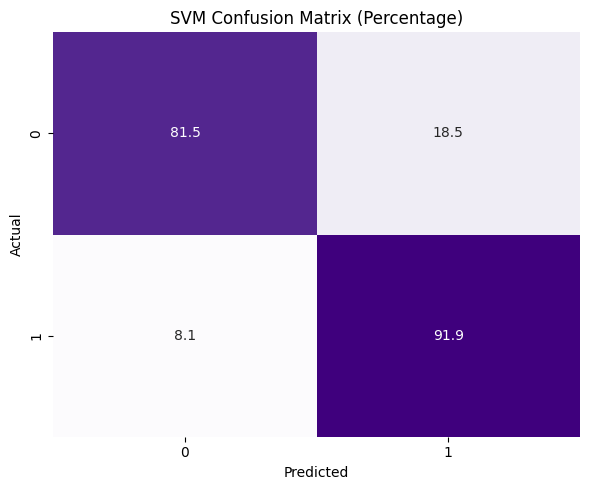

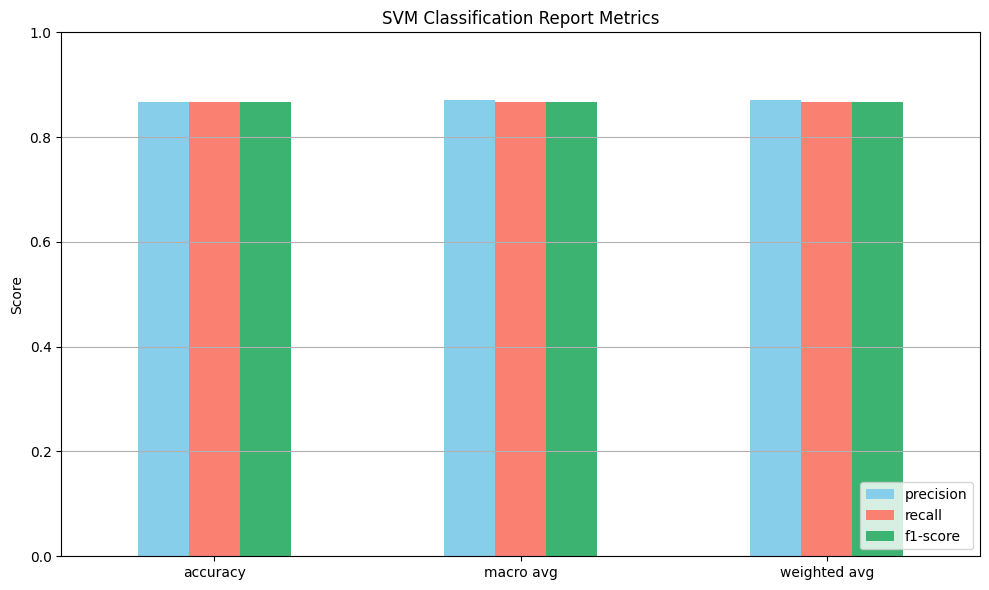

In [ ]:
# === Validation ===
val_preds_svm = svm_model.predict(X_val)
print("\n=== SVM Validation Accuracy:", accuracy_score(y_val, val_preds_svm))

# === Final Test ===
svm_preds = svm_model.predict(X_test)
print("\n=== SVM Test Results ===")
print("Accuracy:", accuracy_score(y_test, svm_preds))

# Confusion Matrix (percentages)
cm = confusion_matrix(y_test, svm_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Purples", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("SVM Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report as Histogram
report_dict = classification_report(y_test, svm_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(columns="support", errors='ignore')

# Keep only overall metrics
overall_rows = ["accuracy", "macro avg", "weighted avg"]
report_df_filtered = report_df.loc[overall_rows]

report_df_filtered.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon', 'mediumseagreen'])
plt.title("SVM Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()




In [ ]:
# run for nearly 3 hours
#if not urgent, don't excute

# Tune Hyperparameters SVM

# Define hyperparameter grid
param_grid = [
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'degree': [2, 3]},
    {'kernel': ['sigmoid'], 'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
    {'kernel': ['linear'], 'C': [0.1, 1, 10]}  # gamma not used for linear kernel
]

grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train, y_train)

# Show best parameters
print("Best parameters (Grid Search):", grid.best_params_)
print("Best accuracy:", grid.best_score_)

# Store results for plotting
grid_results = pd.DataFrame(grid.cv_results_)


Best parameters (Grid Search): {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best accuracy: 0.9673557742281972


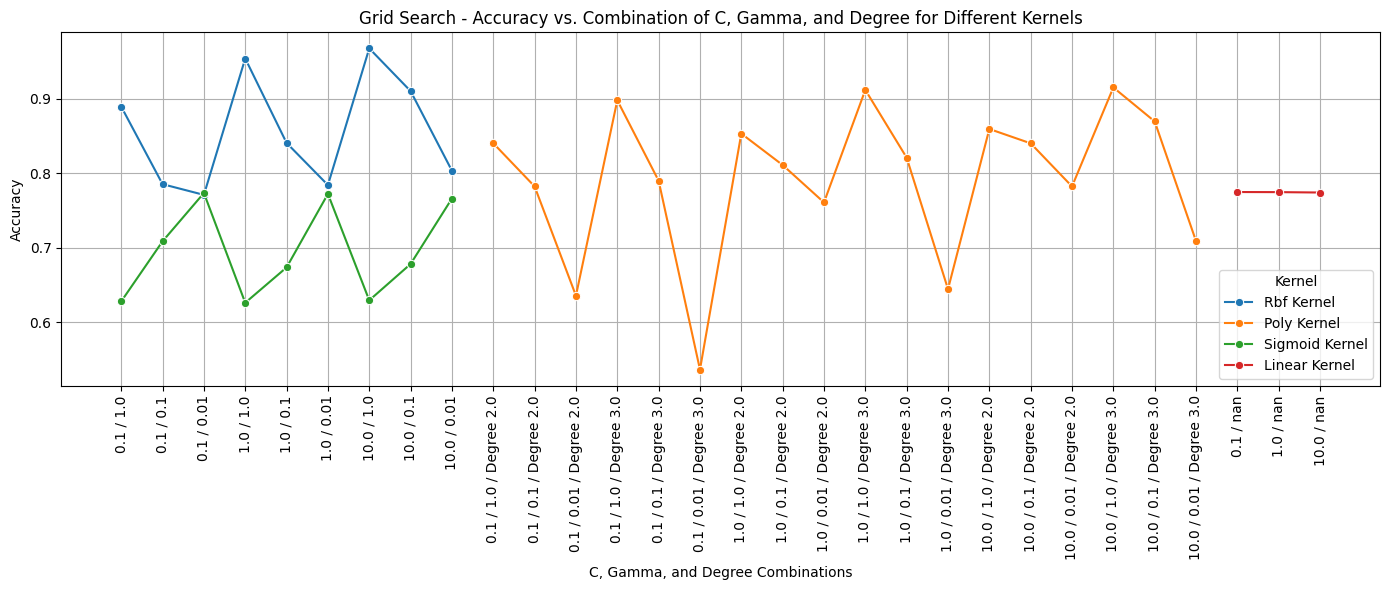

In [ ]:

# Create a new column for the combination of C, gamma, and degree (for poly kernel)
grid_results["C_gamma_degree"] = (
    grid_results["param_C"].astype(str) + " / " + grid_results["param_gamma"].astype(str)
)
# For 'poly' kernel, include degree in the label
grid_results["C_gamma_degree"] = grid_results.apply(
    lambda row: row["C_gamma_degree"] + " / Degree " + str(row["param_degree"])
    if row["param_kernel"] == "poly" else row["C_gamma_degree"], axis=1
)

# Plot all kernels in one plot
plt.figure(figsize=(14, 6))

# Iterate through each kernel type and plot its data
for kernel in grid_results["param_kernel"].unique():
    kernel_data = grid_results[grid_results["param_kernel"] == kernel]
    sns.lineplot(data=kernel_data, x="C_gamma_degree", y="mean_test_score",
                 label=f"{kernel.capitalize()} Kernel", marker="o")

# Customize plot
plt.title("Grid Search - Accuracy vs. Combination of C, Gamma, and Degree for Different Kernels")
plt.xlabel("C, Gamma, and Degree Combinations")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend(title="Kernel", loc='lower right')
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
#run for 30 min

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-2, 20)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 10)
    model = SVC(kernel='rbf', C=C, gamma=gamma, probability=True)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best parameters (Optuna):", study.best_params)
print("Best accuracy:", study.best_value)


[I 2025-05-13 16:22:31,782] A new study created in memory with name: no-name-d4dc8b79-5bb5-4e5d-8dc2-821192e00e32
[I 2025-05-13 16:23:37,175] Trial 0 finished with value: 0.5712969058591179 and parameters: {'C': 0.05793067353434431, 'gamma': 0.00020057238369909462}. Best is trial 0 with value: 0.5712969058591179.
[I 2025-05-13 16:24:13,114] Trial 1 finished with value: 0.7787265687259624 and parameters: {'C': 1.6703163090872069, 'gamma': 0.002382179647733548}. Best is trial 1 with value: 0.7787265687259624.
[I 2025-05-13 16:25:16,656] Trial 2 finished with value: 0.7281792037697932 and parameters: {'C': 0.05278721561990091, 'gamma': 0.0008991458113218078}. Best is trial 1 with value: 0.7787265687259624.
[I 2025-05-13 16:25:51,655] Trial 3 finished with value: 0.7799113856068742 and parameters: {'C': 1.5854530800645201, 'gamma': 0.0030924664772634574}. Best is trial 3 with value: 0.7799113856068742.
[I 2025-05-13 16:26:28,640] Trial 4 finished with value: 0.7785948165344235 and paramete

Best parameters (Optuna): {'C': 2.2760229565134917, 'gamma': 4.5058050747679035}
Best accuracy: 0.9724891722393542


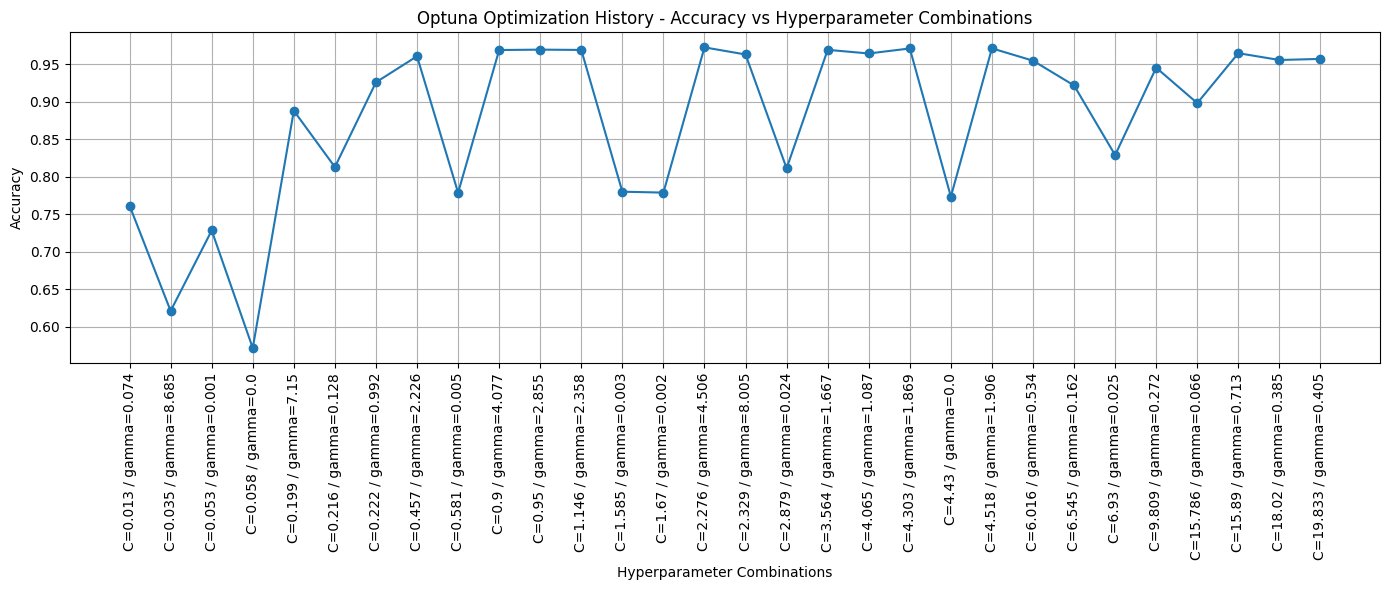

In [ ]:

# Extract trial data
trials = study.trials_dataframe(attrs=["number", "value", "params"])

# Create new columns for sorting
trials["C"] = trials["params_C"]
trials["gamma"] = trials["params_gamma"]

# Sort by C and then gamma
trials = trials.sort_values(by=["C", "gamma"])

# Create readable hyperparameter labels
trials["hyperparams_combination"] = trials.apply(
    lambda row: f"C={round(row['C'], 3)} / gamma={round(row['gamma'], 3)}", axis=1
)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(trials["hyperparams_combination"], trials["value"], marker="o")
plt.title("Optuna Optimization History - Accuracy vs Hyperparameter Combinations")
plt.xlabel("Hyperparameter Combinations")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()



=== SVM Validation Accuracy: 0.97911227154047

=== SVM Test Results ===
Accuracy: 0.9765319426336375


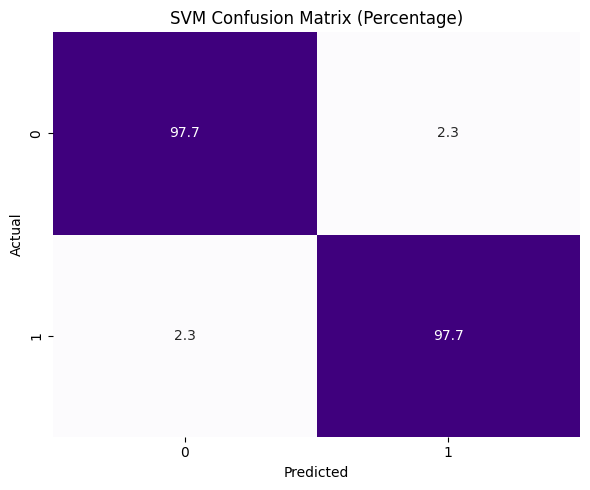

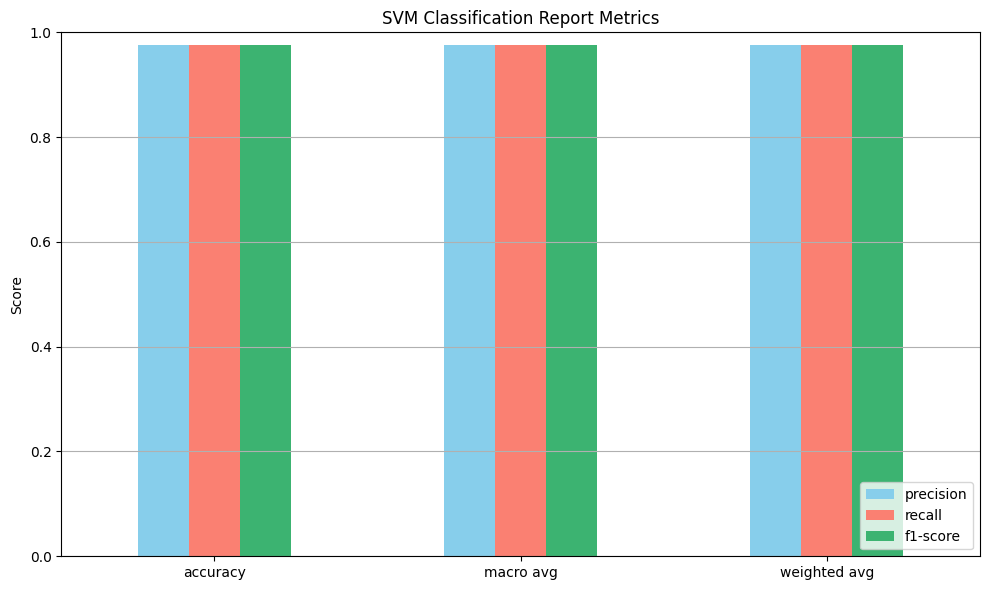

In [ ]:
# Best hyperparameters from Optuna study
best_params = study.best_params
best_C = best_params['C']
best_gamma = best_params['gamma']

# Train the SVM model with the best hyperparameters
svm_model = SVC(kernel='rbf', C=best_C, gamma=best_gamma, probability=True)

# === Validation ===
svm_model.fit(X_train, y_train)  # Fit the model with training data
val_preds_svm = svm_model.predict(X_val)
print("\n=== SVM Validation Accuracy:", accuracy_score(y_val, val_preds_svm))

# === Final Test ===
svm_preds = svm_model.predict(X_test)
print("\n=== SVM Test Results ===")
print("Accuracy:", accuracy_score(y_test, svm_preds))

# Confusion Matrix (percentages)
cm = confusion_matrix(y_test, svm_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Purples", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("SVM Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report as Histogram
report_dict = classification_report(y_test, svm_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(columns="support", errors='ignore')

# Keep only overall metrics
overall_rows = ["accuracy", "macro avg", "weighted avg"]
report_df_filtered = report_df.loc[overall_rows]

report_df_filtered.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon', 'mediumseagreen'])
plt.title("SVM Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### K-Nearest Neighbors (KNN)

In [ ]:

# === K-Nearest Neighbors (KNN) ===
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Validate
val_preds_knn = knn_model.predict(X_val)
print("\n=== KNN Validation Accuracy:", accuracy_score(y_val, val_preds_knn))

# Final test
knn_preds = knn_model.predict(X_test)
print("\n=== KNN Test Results ===")
print("Accuracy:", accuracy_score(y_test, knn_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_preds))
print("Classification Report:\n", classification_report(y_test, knn_preds))



=== KNN Validation Accuracy: 0.9073107049608355

=== KNN Test Results ===
Accuracy: 0.9152542372881356
Confusion Matrix:
 [[321  63]
 [  2 381]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       384
           1       0.86      0.99      0.92       383

    accuracy                           0.92       767
   macro avg       0.93      0.92      0.91       767
weighted avg       0.93      0.92      0.91       767




=== KNN Validation Accuracy: 0.9073107049608355

=== KNN Test Results ===
Accuracy: 0.9152542372881356


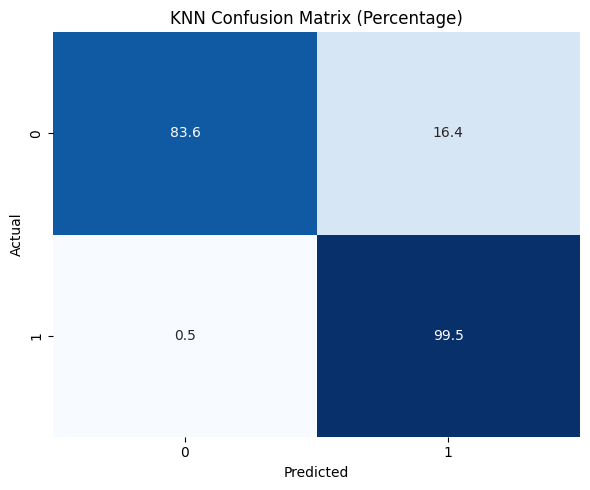

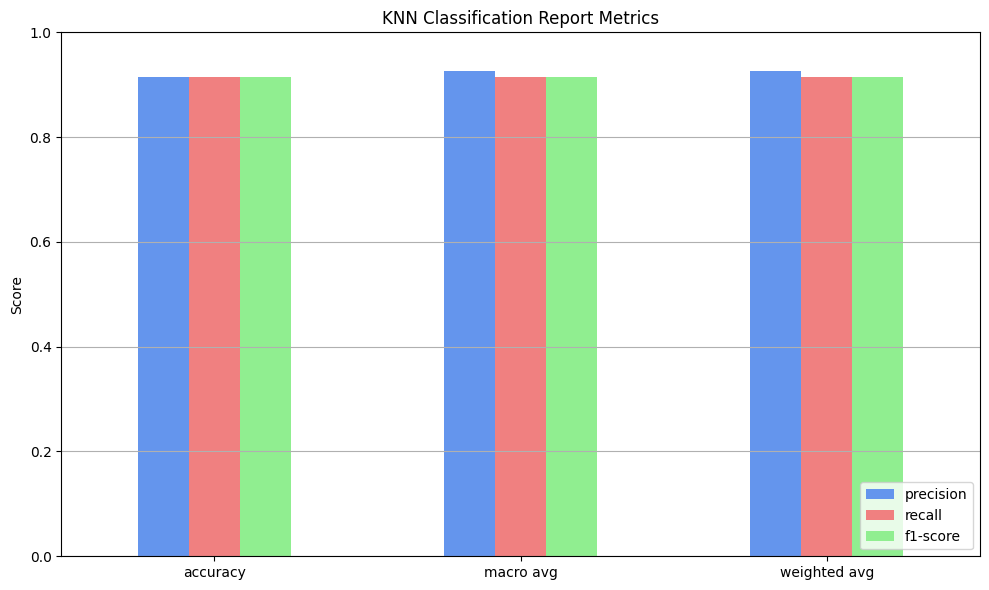

In [ ]:

# === Train KNN ===
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust this
knn_model.fit(X_train, y_train)

# === Validation ===
val_preds_knn = knn_model.predict(X_val)
print("\n=== KNN Validation Accuracy:", accuracy_score(y_val, val_preds_knn))

# === Final Test ===
knn_preds = knn_model.predict(X_test)
print("\n=== KNN Test Results ===")
print("Accuracy:", accuracy_score(y_test, knn_preds))

# Confusion Matrix (percentages)
cm = confusion_matrix(y_test, knn_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("KNN Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report as Histogram
report_dict = classification_report(y_test, knn_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(columns="support", errors='ignore')

# Keep only overall metrics
overall_rows = ["accuracy", "macro avg", "weighted avg"]
report_df_filtered = report_df.loc[overall_rows]

report_df_filtered.plot(kind='bar', figsize=(10, 6), color=['cornflowerblue', 'lightcoral', 'lightgreen'])
plt.title("KNN Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
# run for 20 min

param_grid_knn = {
    'n_neighbors': list(range(1, 15)),                  # Try 1 to 20 neighbors
    'weights': ['uniform', 'distance'],                # Voting strategy
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Search algorithm
    'p': [1, 2],                                        # Distance metric: 1 = Manhattan, 2 = Euclidean
    'leaf_size': [1, 5, 10, 20]                   # Leaf size (relevant for tree-based algorithms)
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

print("Best parameters (GridSearchCV):", grid_knn.best_params_)
print("Best cross-validation accuracy:", grid_knn.best_score_)

# Use the best model
knn_model = grid_knn.best_estimator_


Fitting 5 folds for each of 896 candidates, totalling 4480 fits
Best parameters (GridSearchCV): {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9581409168081494


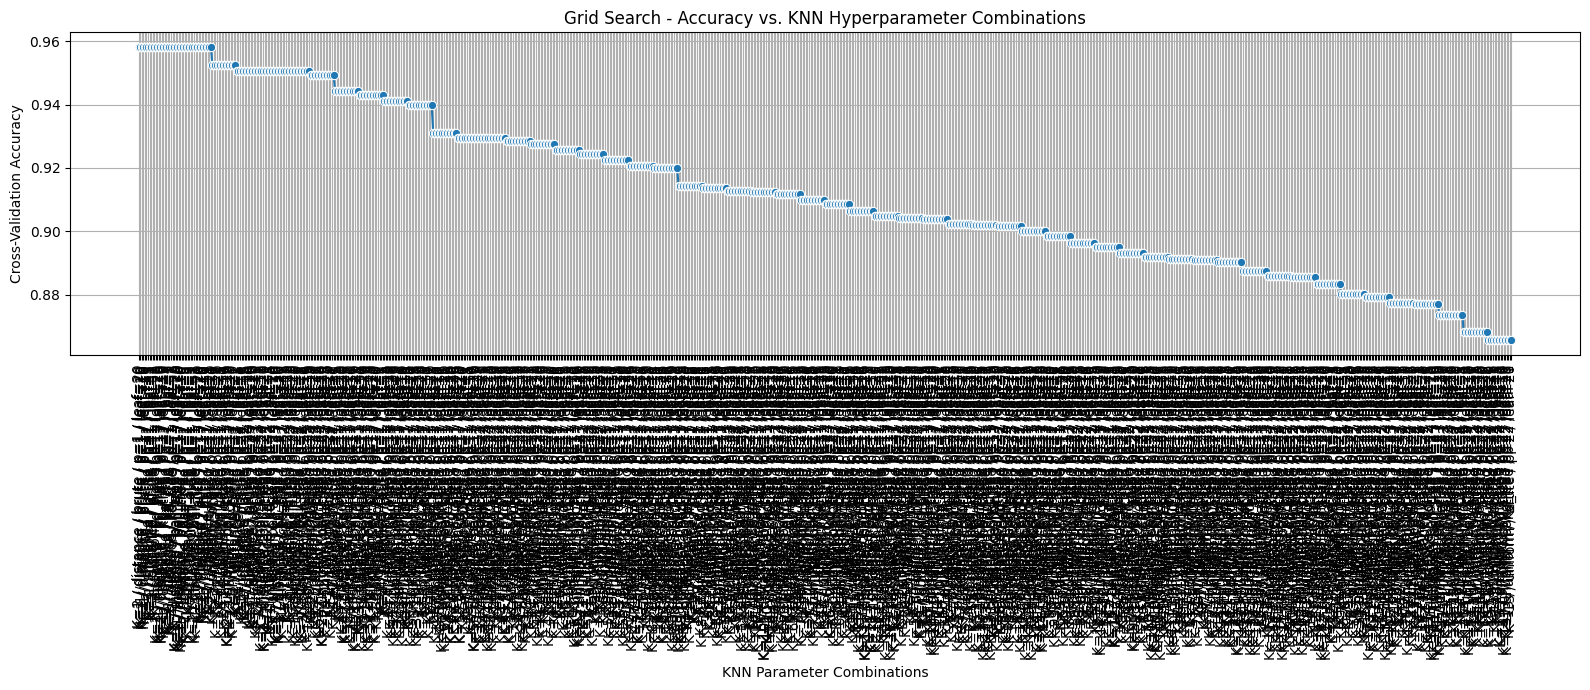

In [ ]:

# Convert cv_results_ to DataFrame
knn_results = pd.DataFrame(grid_knn.cv_results_)

# Create a combined label for key hyperparameters
knn_results["param_combination"] = (
    "K=" + knn_results["param_n_neighbors"].astype(str) +
    " / " + knn_results["param_weights"].astype(str) +
    " / " + knn_results["param_algorithm"].astype(str) +
    " / p=" + knn_results["param_p"].astype(str) +
    " / leaf=" + knn_results["param_leaf_size"].astype(str)
)

# Sort by mean_test_score (optional for nicer plots)
knn_results = knn_results.sort_values(by="mean_test_score", ascending=False)

# Plot
plt.figure(figsize=(16, 7))
sns.lineplot(data=knn_results, x="param_combination", y="mean_test_score",
             marker="o", sort=False)

# Customize plot
plt.title("Grid Search - Accuracy vs. KNN Hyperparameter Combinations")
plt.xlabel("KNN Parameter Combinations")
plt.ylabel("Cross-Validation Accuracy")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()

plt.show()


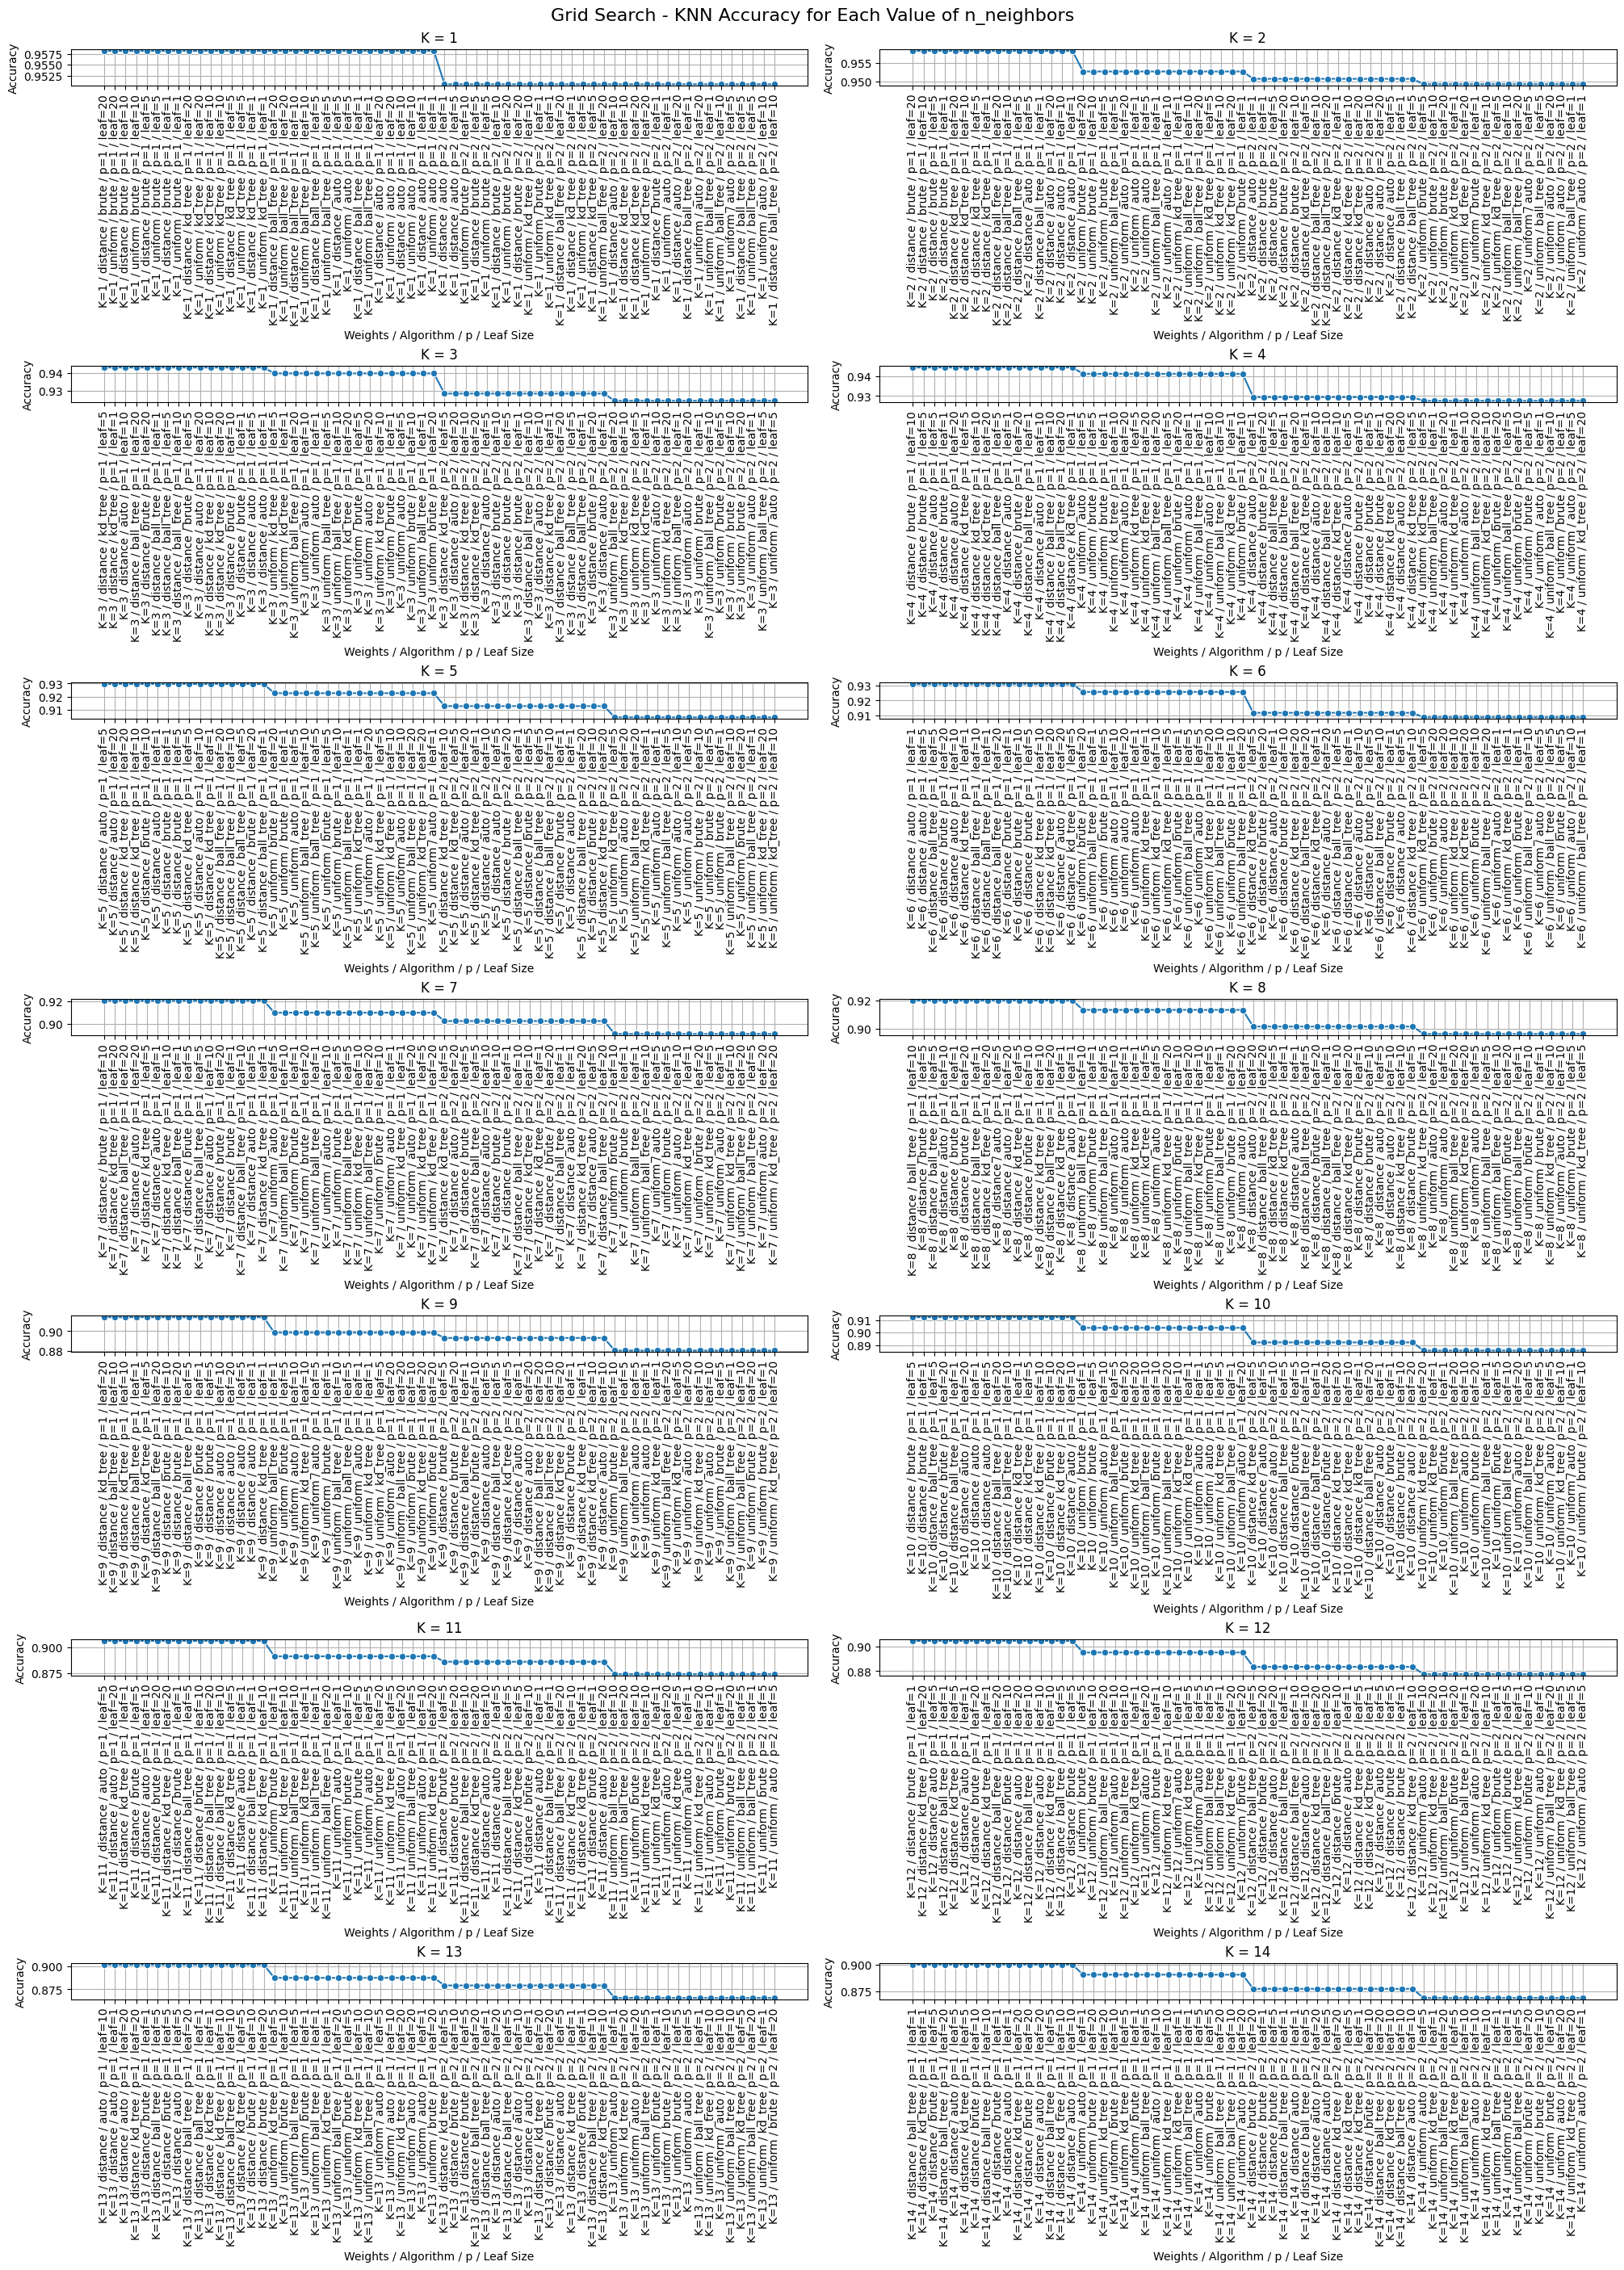

In [ ]:
# Unique n_neighbors values
unique_neighbors = sorted(knn_results["param_n_neighbors"].unique())
n_plots = len(unique_neighbors)

# Calculate number of rows/columns dynamically
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Plot each n_neighbors group
for i, n in enumerate(unique_neighbors):
    subset = knn_results[knn_results["param_n_neighbors"] == n]

    sns.lineplot(data=subset, x="param_combination", y="mean_test_score",
                 marker="o", ax=axes[i])

    axes[i].set_title(f"K = {n}")
    axes[i].set_xlabel("Weights / Algorithm / p / Leaf Size")
    axes[i].set_ylabel("Accuracy")
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].grid(True)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Grid Search - KNN Accuracy for Each Value of n_neighbors", fontsize=16)
plt.show()


In [ ]:


def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    p = trial.suggest_int('p', 1, 2)
    leaf_size = trial.suggest_int('leaf_size', 1, 30)

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        p=p,
        leaf_size=leaf_size
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Run optimization
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=30)

# Output best result
print("Best parameters (Optuna):", study_knn.best_params)
print("Best cross-validation accuracy:", study_knn.best_value)

# Train final model
knn_model = KNeighborsClassifier(**study_knn.best_params)
knn_model.fit(X_train, y_train)

[I 2025-05-13 17:08:41,732] A new study created in memory with name: no-name-4e66dab1-18b8-4d70-9f03-41859ac14b79
[I 2025-05-13 17:08:42,957] Trial 0 finished with value: 0.8683686462700531 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2, 'leaf_size': 10}. Best is trial 0 with value: 0.8683686462700531.
[I 2025-05-13 17:08:43,643] Trial 1 finished with value: 0.8737658951526281 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'algorithm': 'brute', 'p': 2, 'leaf_size': 21}. Best is trial 1 with value: 0.8737658951526281.
[I 2025-05-13 17:08:44,047] Trial 2 finished with value: 0.9506390111222757 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto', 'p': 2, 'leaf_size': 23}. Best is trial 2 with value: 0.9506390111222757.
[I 2025-05-13 17:08:44,809] Trial 3 finished with value: 0.9201003083746231 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'p': 1, 'leaf_size': 17}. Best is trial 2 w

Best parameters (Optuna): {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto', 'p': 2, 'leaf_size': 23}
Best cross-validation accuracy: 0.9506390111222757


KNeighborsClassifier(leaf_size=23, n_neighbors=2, weights='distance')

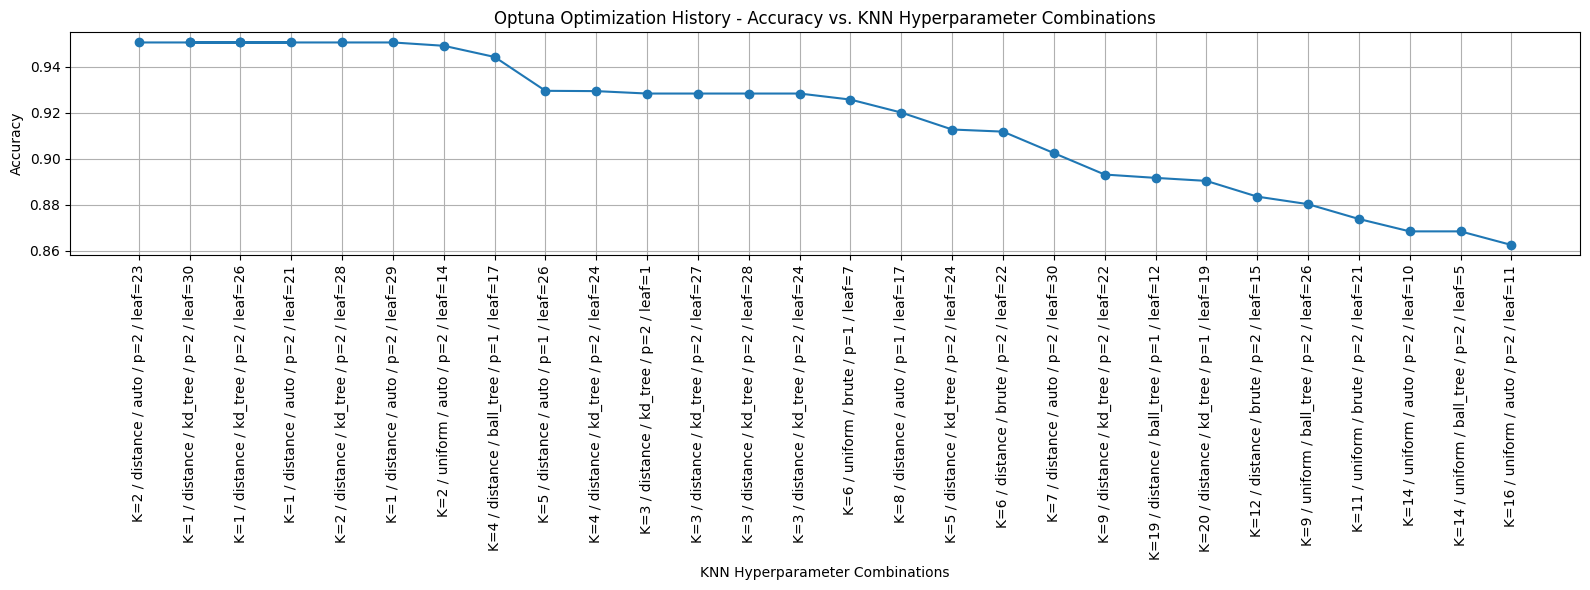

In [ ]:

# Extract trial data from the KNN study
trials = study_knn.trials_dataframe(attrs=["number", "value", "params"])

# Combine all KNN hyperparameters into a single string label
trials["hyperparams_combination"] = trials.apply(
    lambda row: (
        f"K={row['params_n_neighbors']} / "
        f"{row['params_weights']} / "
        f"{row['params_algorithm']} / "
        f"p={row['params_p']} / "
        f"leaf={row['params_leaf_size']}"
    ),
    axis=1
)

# Sort by accuracy for clearer plotting (optional)
trials = trials.sort_values(by="value", ascending=False)

# Plot the optimization history with combined hyperparameters
plt.figure(figsize=(16, 6))
plt.plot(trials["hyperparams_combination"], trials["value"], marker="o")
plt.title("Optuna Optimization History - Accuracy vs. KNN Hyperparameter Combinations")
plt.xlabel("KNN Hyperparameter Combinations")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()



=== KNN Validation Accuracy: 0.9621409921671018

=== KNN Test Results ===
Accuracy: 0.9595827900912647


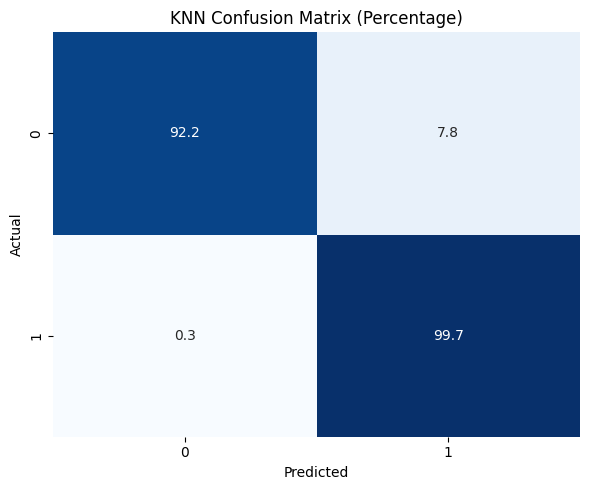

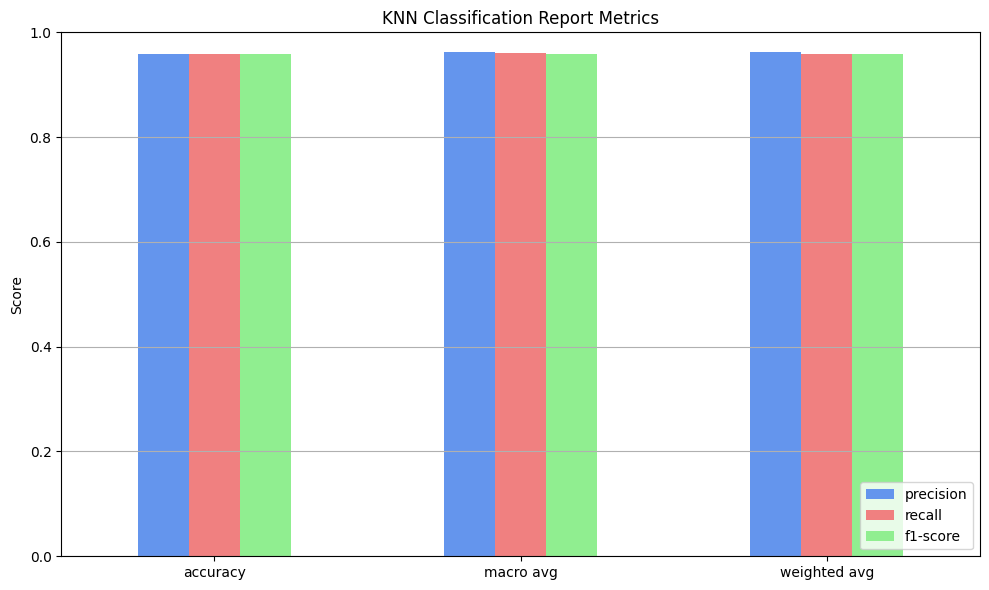

In [ ]:

# === Use Best Parameters from Optuna ===
best_params = study_knn.best_params  # Get best parameters from Optuna study

# Train KNN with best parameters
knn_model = KNeighborsClassifier(**best_params)
knn_model.fit(X_train, y_train)

# === Validation ===
val_preds_knn = knn_model.predict(X_val)
print("\n=== KNN Validation Accuracy:", accuracy_score(y_val, val_preds_knn))

# === Final Test ===
knn_preds = knn_model.predict(X_test)
print("\n=== KNN Test Results ===")
print("Accuracy:", accuracy_score(y_test, knn_preds))

# Confusion Matrix (percentages)
cm = confusion_matrix(y_test, knn_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("KNN Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report as Histogram
report_dict = classification_report(y_test, knn_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(columns="support", errors='ignore')

# Keep only overall metrics
overall_rows = ["accuracy", "macro avg", "weighted avg"]
report_df_filtered = report_df.loc[overall_rows]

report_df_filtered.plot(kind='bar', figsize=(10, 6), color=['cornflowerblue', 'lightcoral', 'lightgreen'])
plt.title("KNN Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Decision Trees

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)
val_preds = tree_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Classification Report:\n", classification_report(y_val, val_preds))

Validation Accuracy: 0.8093994778067886
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.79       383
           1       0.77      0.88      0.82       383

    accuracy                           0.81       766
   macro avg       0.82      0.81      0.81       766
weighted avg       0.82      0.81      0.81       766




=== Decision Tree Baseline Test Results ===
Accuracy: 0.9361147327249022


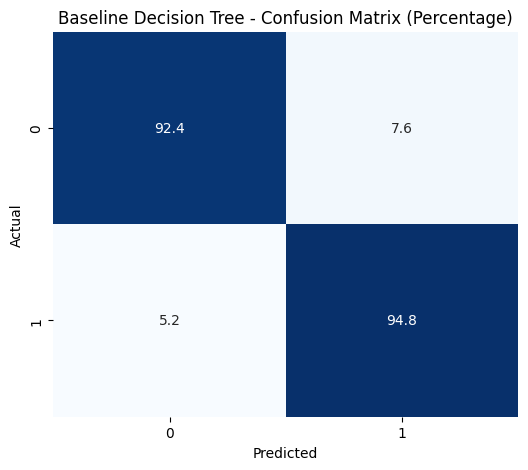

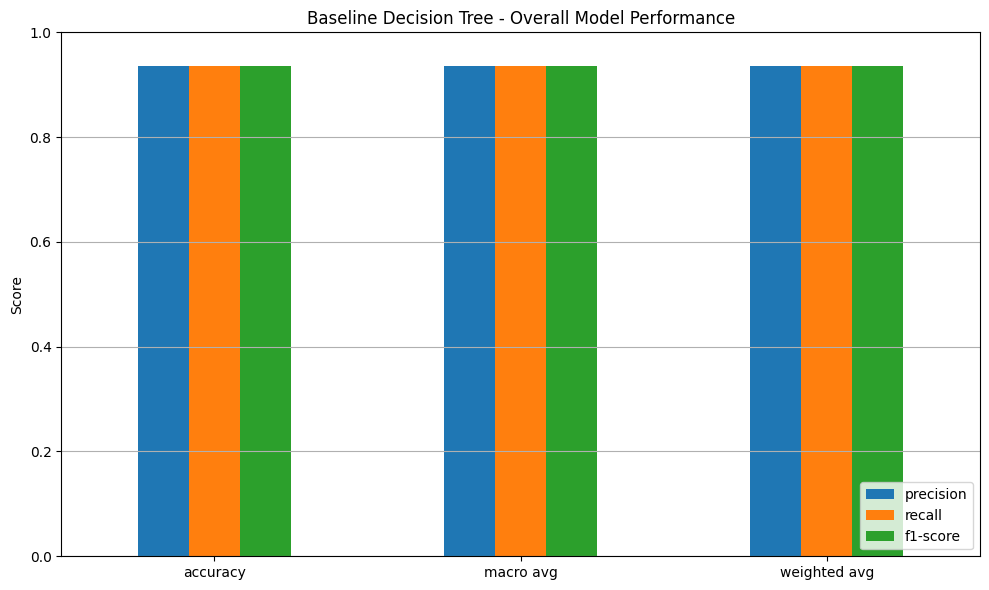

In [ ]:
# === 1. Before Optuna (Baseline Decision Tree) ===
# Initialize and train the baseline decision tree model
dt_model_baseline = DecisionTreeClassifier(random_state=42)
dt_model_baseline.fit(X_train, y_train)

# Predict and evaluate accuracy
dt_preds_baseline = dt_model_baseline.predict(X_test)
print("\n=== Decision Tree Baseline Test Results ===")
print("Accuracy:", accuracy_score(y_test, dt_preds_baseline))

# Confusion Matrix (percentages)
cm_baseline = confusion_matrix(y_test, dt_preds_baseline)
cm_percent_baseline = cm_baseline.astype('float') / cm_baseline.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent_baseline, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Baseline Decision Tree - Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Get classification report as a DataFrame
report_dict_baseline = classification_report(y_test, dt_preds_baseline, output_dict=True)
report_df_baseline = pd.DataFrame(report_dict_baseline).transpose()

# Drop the 'support' column if it exists
report_df_baseline = report_df_baseline.drop(columns="support", errors='ignore')

# Keep only overall metrics
overall_rows_baseline = ["accuracy", "macro avg", "weighted avg"]
report_df_baseline_filtered = report_df_baseline.loc[overall_rows_baseline]

# Plot the baseline classification report as a bar chart
report_df_baseline_filtered.plot(kind='bar', figsize=(10, 6))
plt.title("Baseline Decision Tree - Overall Model Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Define the model
tree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [12, 15, 17, 20, 25, 30],
    'min_samples_split': [2, 5, 10],          # ⚠️ 1 is invalid
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


# Grid search with cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
best_tree = grid_search.best_estimator_

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


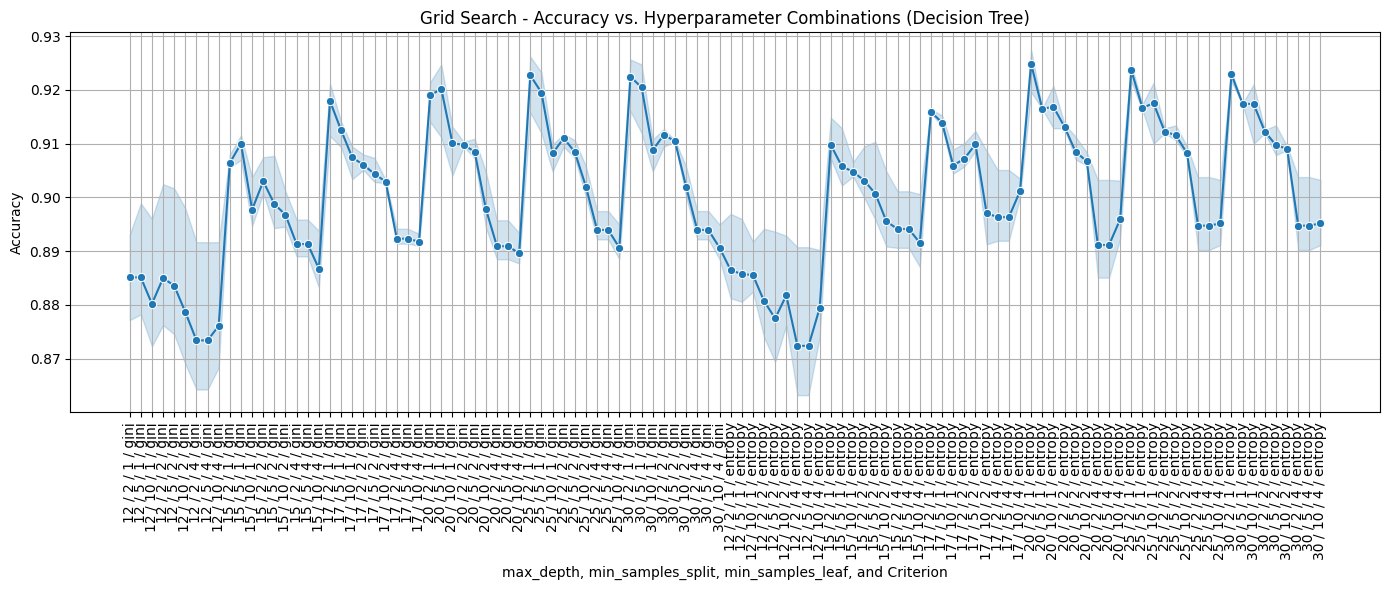

In [ ]:

# Convert the results into a DataFrame if you haven't already
results_df = pd.DataFrame(grid_search.cv_results_)

# Create a new column for the combination of max_depth, min_samples_split, and min_samples_leaf
#didn't add the rest of hyperparameters as the best is the default value
results_df["max_depth_split_leaf"] = (
    results_df["param_max_depth"].astype(str) + " / " + results_df["param_min_samples_split"].astype(str)
    + " / " + results_df["param_min_samples_leaf"].astype(str)
)

# For 'gini' and 'entropy' criterion, include the criterion in the label
results_df["max_depth_split_leaf"] = results_df.apply(
    lambda row: row["max_depth_split_leaf"] + " / " + str(row["param_criterion"]),
    axis=1
)

# Plot all results in one plot
plt.figure(figsize=(14, 6))

# Iterate through each combination of hyperparameters and plot its accuracy
sns.lineplot(data=results_df, x="max_depth_split_leaf", y="mean_test_score", marker="o")

# Customize the plot
plt.title("Grid Search - Accuracy vs. Hyperparameter Combinations (Decision Tree)")
plt.xlabel("max_depth, min_samples_split, min_samples_leaf, and Criterion")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def objective(trial):
    # Suggest values for hyperparameters
    max_depth = trial.suggest_int('max_depth', 3, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical(
        'max_features', [None, 'sqrt', 'log2']
    )  # You could also add float values if desired

    # Create and train model
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        max_features=max_features,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Evaluate on validation set
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return acc  # maximize accuracy

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Results
print("Best Parameters:", study.best_params)
print("Best Accuracy:", study.best_value)

# Train final model with best params
final_tree = DecisionTreeClassifier(
    **study.best_params,
    random_state=42
)
final_tree.fit(X_train, y_train)

# Evaluate
val_preds = final_tree.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))


[I 2025-05-13 17:18:33,513] A new study created in memory with name: no-name-9115bee8-9955-4ae5-983a-8ec38169cece
[I 2025-05-13 17:18:33,577] Trial 0 finished with value: 0.9190600522193212 and parameters: {'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': None}. Best is trial 0 with value: 0.9190600522193212.
[I 2025-05-13 17:18:33,638] Trial 1 finished with value: 0.933420365535248 and parameters: {'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'entropy', 'max_features': None}. Best is trial 1 with value: 0.933420365535248.
[I 2025-05-13 17:18:33,692] Trial 2 finished with value: 0.9073107049608355 and parameters: {'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': None}. Best is trial 1 with value: 0.933420365535248.
[I 2025-05-13 17:18:33,711] Trial 3 finished with value: 0.9347258485639687 and parameters: {'max_depth': 44, 'min_samples_split': 9, 

Best Parameters: {'max_depth': 42, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': 'sqrt'}
Best Accuracy: 0.9464751958224543
Validation Accuracy: 0.9464751958224543


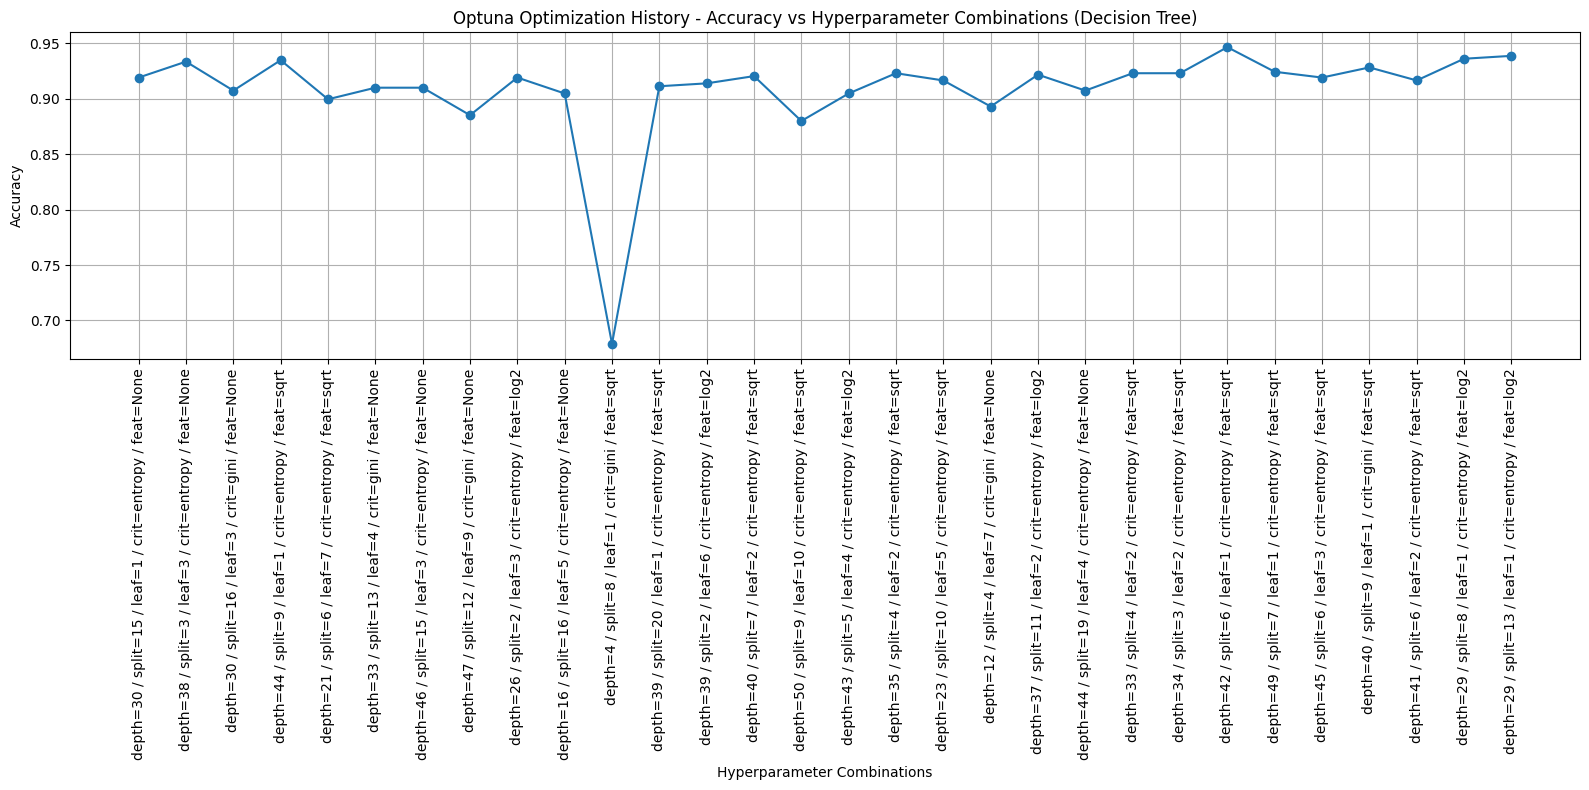

In [ ]:
# Extract trial data from the study
trials = study.trials_dataframe(attrs=["number", "value", "params"])

# Combine key hyperparameters including max_features
trials["hyperparams_combination"] = trials.apply(
    lambda row: f"depth={round(row['params_max_depth'], 3)}"
                f" / split={round(row['params_min_samples_split'], 3)}"
                f" / leaf={round(row['params_min_samples_leaf'], 3)}"
                f" / crit={row['params_criterion']}"
                f" / feat={row.get('params_max_features', 'None')}",  # handle missing values safely
    axis=1
)

# Plot the optimization history
plt.figure(figsize=(16, 8))
plt.plot(trials["hyperparams_combination"], trials["value"], marker="o")
plt.title("Optuna Optimization History - Accuracy vs Hyperparameter Combinations (Decision Tree)")
plt.xlabel("Hyperparameter Combinations")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()



=== Tuned Decision Tree Test Results ===
Accuracy: 0.9530638852672751


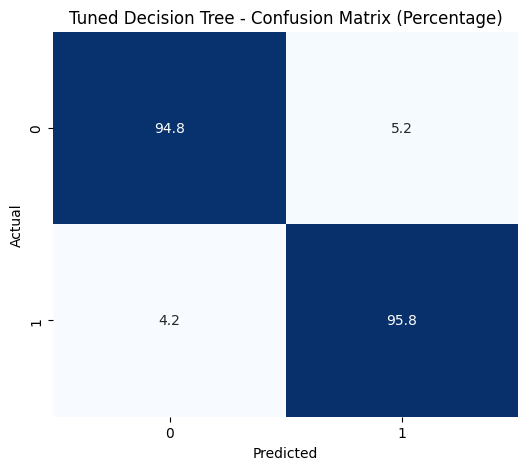

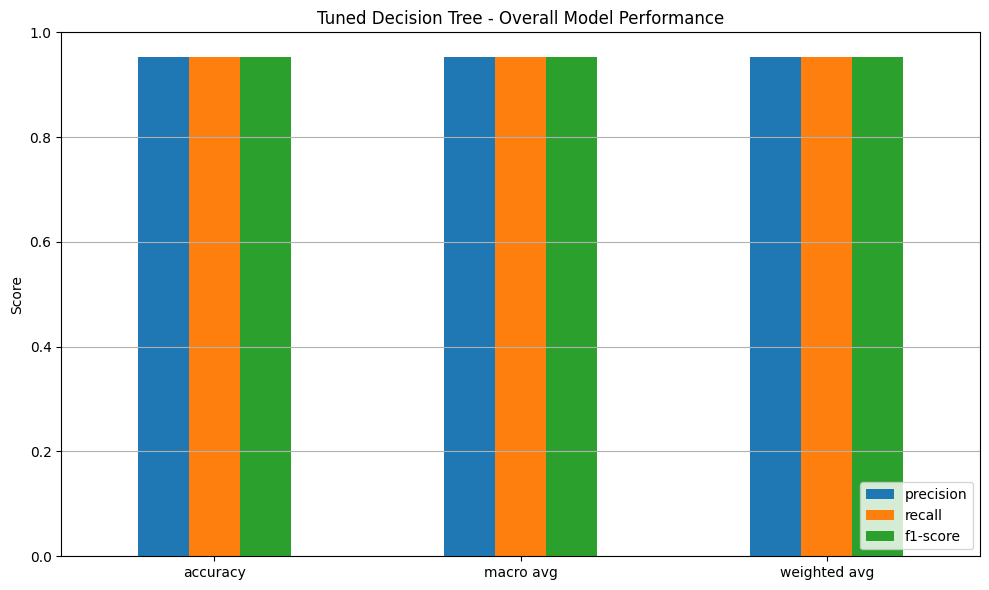

In [ ]:
# === 2. After Optuna (Tuned Decision Tree) ===
# Assuming you have already run the Optuna optimization (as shown in earlier steps)
# Get the best parameters found by Optuna
best_params = study.best_params

# Train the Decision Tree with the best parameters from Optuna
dt_model_tuned = DecisionTreeClassifier(
    max_depth=best_params.get('max_depth'),
    min_samples_split=best_params.get('min_samples_split'),
    min_samples_leaf=best_params.get('min_samples_leaf'),
    criterion=best_params.get('criterion'),
    max_features=best_params.get('max_features', None),
    random_state=42
)


dt_model_tuned.fit(X_train, y_train)

# Predict and evaluate accuracy for the tuned model
dt_preds_tuned = dt_model_tuned.predict(X_test)
print("\n=== Tuned Decision Tree Test Results ===")
print("Accuracy:", accuracy_score(y_test, dt_preds_tuned))

# Confusion Matrix (percentages) for the tuned model
cm_tuned = confusion_matrix(y_test, dt_preds_tuned)
cm_percent_tuned = cm_tuned.astype('float') / cm_tuned.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent_tuned, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Tuned Decision Tree - Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Get classification report as a DataFrame for the tuned model
report_dict_tuned = classification_report(y_test, dt_preds_tuned, output_dict=True)
report_df_tuned = pd.DataFrame(report_dict_tuned).transpose()

# Drop the 'support' column if it exists
report_df_tuned = report_df_tuned.drop(columns="support", errors='ignore')

# Keep only overall metrics
overall_rows_tuned = ["accuracy", "macro avg", "weighted avg"]
report_df_tuned_filtered = report_df_tuned.loc[overall_rows_tuned]

# Plot the tuned classification report as a bar chart
report_df_tuned_filtered.plot(kind='bar', figsize=(10, 6))
plt.title("Tuned Decision Tree - Overall Model Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


=== Tuned Decision Tree Test Results ===
Accuracy: 0.9322033898305084


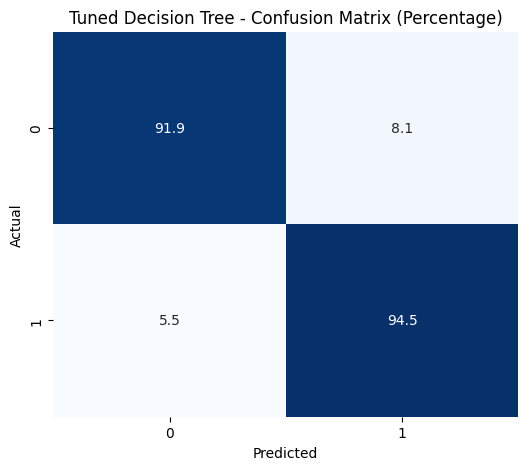

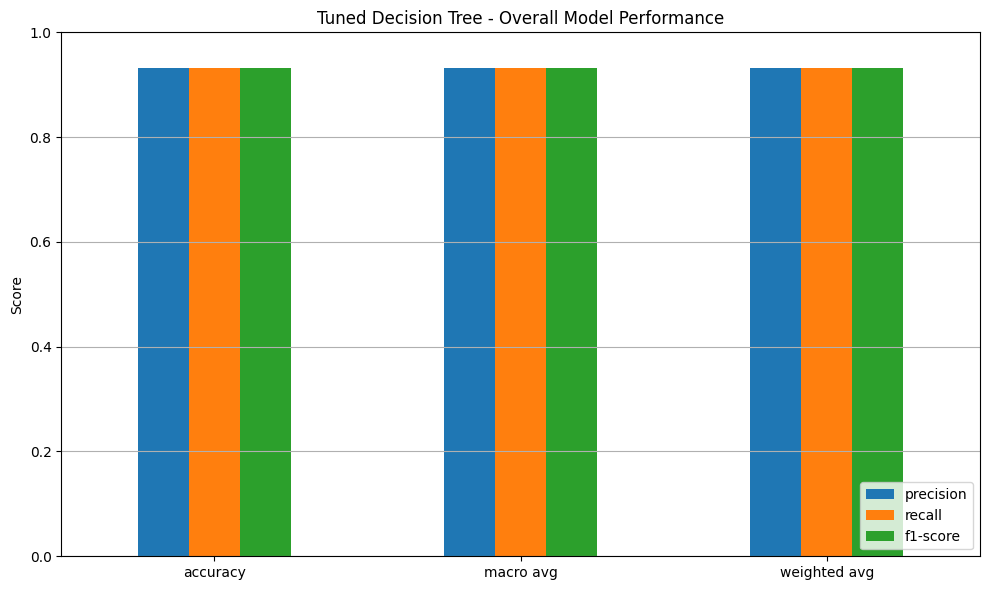

In [ ]:
# === 2. After GridSearchCV (Tuned Decision Tree) ===

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Train the Decision Tree with the best parameters
dt_model_tuned = DecisionTreeClassifier(
    max_depth=best_params.get('max_depth'),
    min_samples_split=best_params.get('min_samples_split'),
    min_samples_leaf=best_params.get('min_samples_leaf'),
    criterion=best_params.get('criterion'),
    max_features=best_params.get('max_features', None),
    random_state=42
)

# Fit the model
dt_model_tuned.fit(X_train, y_train)

# Predict and evaluate accuracy
dt_preds_tuned = dt_model_tuned.predict(X_test)
print("\n=== Tuned Decision Tree Test Results ===")
print("Accuracy:", accuracy_score(y_test, dt_preds_tuned))

# Confusion Matrix (percentages)
cm_tuned = confusion_matrix(y_test, dt_preds_tuned)
cm_percent_tuned = cm_tuned.astype('float') / cm_tuned.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent_tuned, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Tuned Decision Tree - Confusion Matrix (Percentage)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
report_dict_tuned = classification_report(y_test, dt_preds_tuned, output_dict=True)
report_df_tuned = pd.DataFrame(report_dict_tuned).transpose()

# Drop support column if it exists
report_df_tuned = report_df_tuned.drop(columns="support", errors='ignore')

# Keep only overall metrics
overall_rows_tuned = ["accuracy", "macro avg", "weighted avg"]
report_df_tuned_filtered = report_df_tuned.loc[overall_rows_tuned]

# Plot performance metrics
report_df_tuned_filtered.plot(kind='bar', figsize=(10, 6))
plt.title("Tuned Decision Tree - Overall Model Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Comparison

In [ ]:
report_dict_nb = classification_report(y_test, nb_preds, output_dict=True)
report_df_nb = pd.DataFrame(report_dict_nb).transpose()
report_df_nb = report_df_nb.drop(columns="support", errors='ignore')
report_df_nb_filtered = report_df_nb.loc[["accuracy", "macro avg", "weighted avg"]]

report_dict_svm = classification_report(y_test, svm_preds, output_dict=True)
report_df_svm = pd.DataFrame(report_dict_svm).transpose()
report_df_svm = report_df_svm.drop(columns="support", errors='ignore')
report_df_svm_filtered = report_df_svm.loc[["accuracy", "macro avg", "weighted avg"]]

report_dict_knn = classification_report(y_test, knn_preds, output_dict=True)
report_df_knn = pd.DataFrame(report_dict_knn).transpose()
report_df_knn = report_df_knn.drop(columns="support", errors='ignore')
report_df_knn_filtered = report_df_knn.loc[["accuracy", "macro avg", "weighted avg"]]

# Use the tuned Decision Tree predictions but keep the same variable name for consistency
report_dict_dt_baseline = classification_report(y_test, dt_preds_baseline, output_dict=True)
report_df_dt_baseline = pd.DataFrame(report_dict_dt_baseline).transpose()
report_df_dt_baseline = report_df_dt_baseline.drop(columns="support", errors='ignore')
report_df_dt_baseline_filtered = report_df_dt_baseline.loc[["accuracy", "macro avg", "weighted avg"]]


<Figure size 1000x600 with 0 Axes>

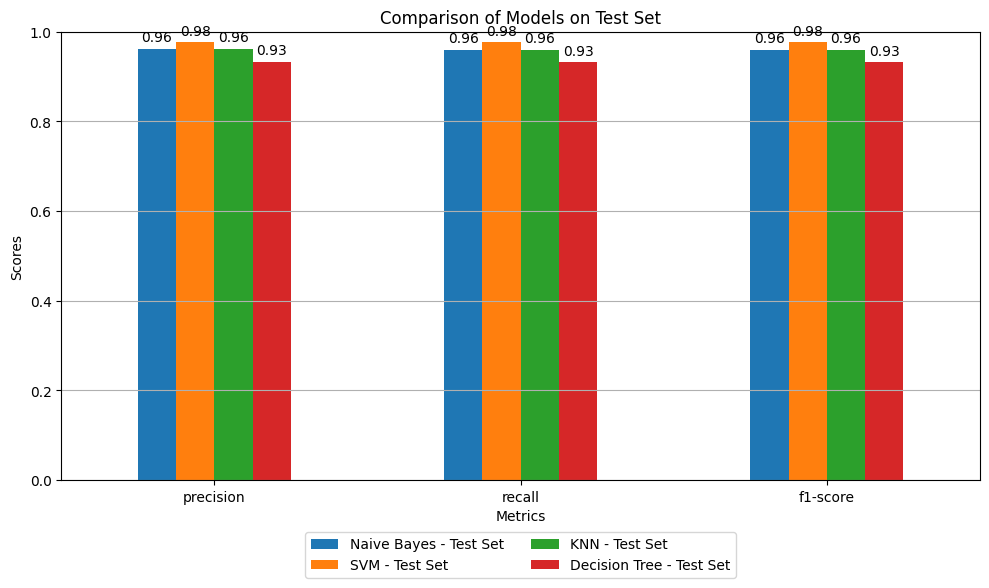

In [ ]:

# Extract weighted avg scores
nb_scores = pd.Series(report_dict["weighted avg"])[["precision", "recall", "f1-score"]]
svm_scores = pd.Series(report_dict_svm["weighted avg"])[["precision", "recall", "f1-score"]]
knn_scores = pd.Series(report_dict_knn["weighted avg"])[["precision", "recall", "f1-score"]]
dt_scores = pd.Series(report_dict_tuned["weighted avg"])[["precision", "recall", "f1-score"]]

# Combine into a single DataFrame (metrics as rows, models as columns)
comparison_df = pd.DataFrame({
    "Naive Bayes - Test Set": nb_scores,
    "SVM - Test Set": svm_scores,
    "KNN - Test Set": knn_scores,
    "Decision Tree - Test Set": dt_scores
})

# Plot
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', figsize=(10, 6))

plt.title("Comparison of Models on Test Set")
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2)

# Annotate bars with score values
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

In [ ]:
# Extract accuracy scores from each model's report
accuracies = {
    "SVM": report_df_svm_filtered.loc["accuracy", "f1-score"],
    "KNN": report_df_knn_filtered.loc["accuracy", "f1-score"],
    "Naive Bayes": report_df_nb_filtered.loc["accuracy", "f1-score"],
    "Decision Tree (Baseline)": report_df_dt_baseline_filtered.loc["accuracy", "f1-score"]
}

# Find the best classifier
best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

# Print the result
print(f"Best Classifier: {best_model}")
print(f"The Accuracy: {best_accuracy:.4f}")

Best Classifier: SVM
The Accuracy: 0.9765


# **Clustring**

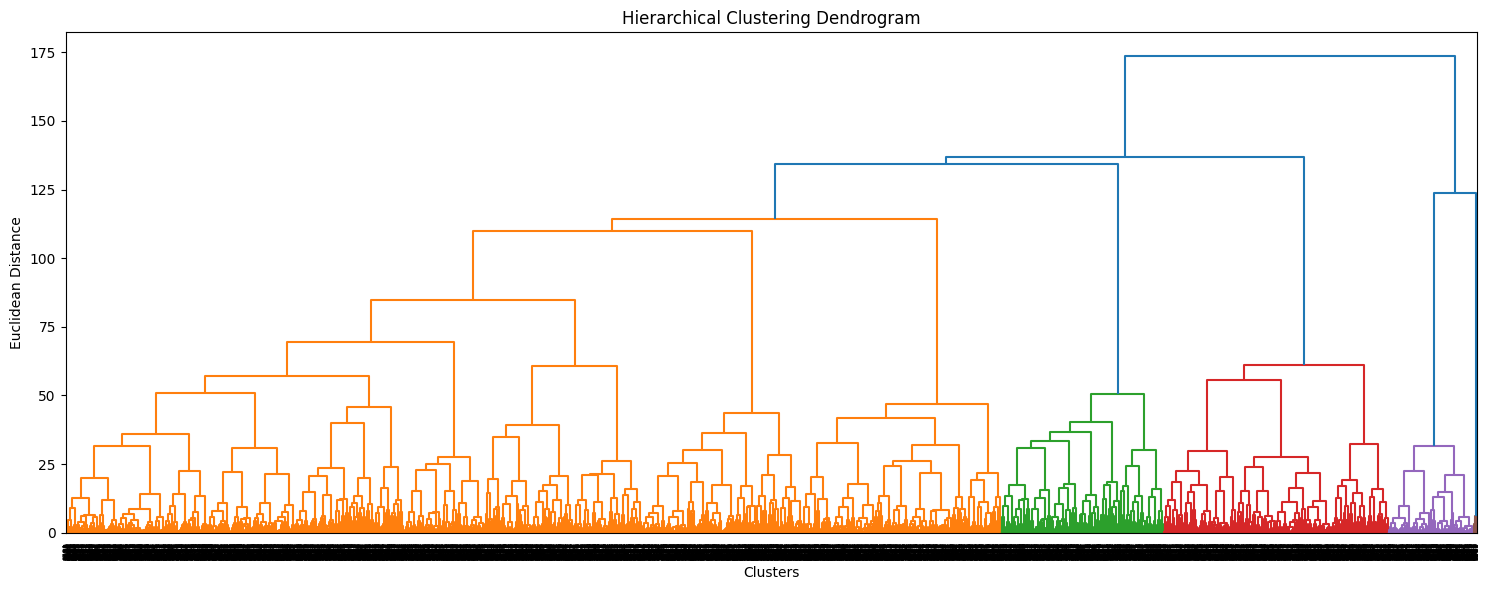

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# 1. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 2. Compute linkage matrix for hierarchical clustering
linked = linkage(X_scaled, method='ward')

# 3. Plot the dendrogram
plt.figure(figsize=(15, 6))
dendrogram(linked,orientation='top', distance_sort='descending',show_leaf_counts=False)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean Distance')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at a specific threshold to get cluster labels
cluster_labels = fcluster(linked, t=125, criterion='distance')

# Create a copy of X_train
X_clustered = pd.DataFrame(X_train).copy()

# Add cluster labels as a new column
X_clustered['Cluster'] = cluster_labels
# Add actual stroke labels
X_clustered['Stroke'] = y_train.values

# Stroke rate per cluster
stroke_distribution = pd.crosstab(X_clustered['Cluster'], X_clustered['Stroke'], normalize='index') * 100
stroke_distribution.columns = ['No Stroke (%)', 'Stroke (%)']
print(stroke_distribution)


         No Stroke (%)  Stroke (%)
Cluster                           
1            98.529412    1.470588
2            37.168874   62.831126
3            18.400000   81.600000
4            53.969829   46.030171


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Average feature values per cluster
cluster_means = X_clustered.groupby('Cluster').mean(numeric_only=True)
print(cluster_means)


           gender       age  hypertension  heart_disease  ever_married  \
Cluster                                                                  
1        0.509901 -1.623803     -0.321807      -0.222025      0.001536   
2        0.323386  1.126439      1.117459      -0.231583      0.957380   
3        0.639342  1.236661      0.711368       4.318112      0.912946   
4        0.387656  0.465072      0.139693      -0.231583      0.801451   

         Residence_type  avg_glucose_level       bmi  work_type_Never_worked  \
Cluster                                                                        
1              0.515419          -0.291422 -1.101718                0.031513   
2              0.504532           0.319154  0.070674                0.000000   
3              0.548141           1.320298  0.225457                0.000000   
4              0.510484           0.209982  0.157577                0.000000   

         work_type_Private  work_type_Self-employed  work_type_children  \

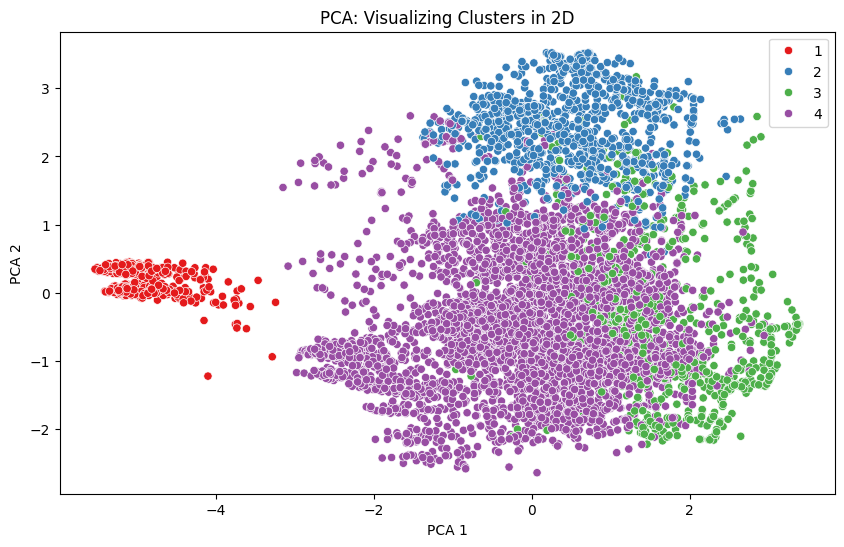

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='Set1')
plt.title("PCA: Visualizing Clusters in 2D")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


In [ ]:
import pandas as pd

# Create DataFrame from X_train
X_kmeans = pd.DataFrame(X_train).copy()

# Add predicted cluster labels
X_kmeans['Cluster'] = kmeans_labels

# Add true stroke labels for analysis
X_kmeans['Stroke'] = y_train.values

# Stroke rate in each cluster
stroke_distribution = pd.crosstab(X_kmeans['Cluster'], X_kmeans['Stroke'], normalize='index') * 100
stroke_distribution.columns = ['No Stroke (%)', 'Stroke (%)']
print(stroke_distribution)


         No Stroke (%)  Stroke (%)
Cluster                           
0            34.373125   65.626875
1            89.539228   10.460772
2            41.465445   58.534555
3            44.848485   55.151515
4            98.481562    1.518438


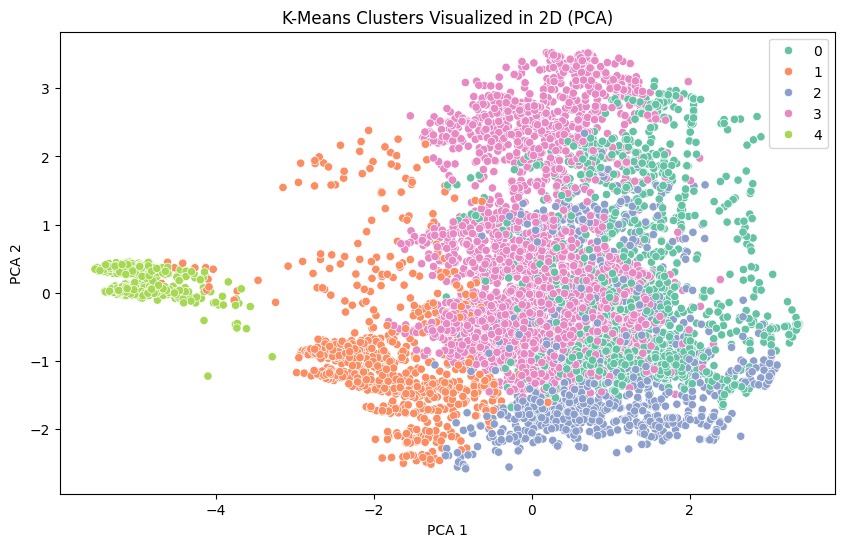

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='Set2')
plt.title("K-Means Clusters Visualized in 2D (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Choose number of clusters from dendrogram
hier_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
hier_labels = hier_clustering.fit_predict(X_scaled)
silhouette_hier = silhouette_score(X_scaled, hier_labels)
print(f"Hierarchical Silhouette Score: {silhouette_hier}")

silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
print(f"K-means Silhouette Score: {silhouette_kmeans}")

Hierarchical Silhouette Score: 0.1979039482671834
K-means Silhouette Score: 0.19037703158027744


In [ ]:
from sklearn.metrics import adjusted_rand_score
ari_hier = adjusted_rand_score(y_train, hier_labels)
print(f"Hierarchical ARI: {ari_hier}")

ari_kmeans = adjusted_rand_score(y_train, kmeans_labels)
print(f"K-means ARI: {ari_kmeans}")

Hierarchical ARI: 0.0262710909645576
K-means ARI: 0.03599768061613992


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Predict K-means labels for X_train
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)  # Fit on X_train
kmeans_labels_train = kmeans.predict(X_train_scaled)

# Predict hierarchical labels for X_train
hier_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
hier_labels_train = hier_clustering.fit_predict(X_train_scaled)
# Labels to compare
labels = {
    'Naive Bayes': nb_preds,
    'SVM': svm_preds,
    'KNN': knn_preds,
    'Decision Tree': dt_preds_baseline,
    'K-means': kmeans_labels_train,
    'Hierarchical': hier_labels_train,
    'True Labels': y_train
}

# Compute ARI and NMI
ari_results = {}
nmi_results = {}
for name1, label1 in labels.items():
    ari_results[name1] = {}
    nmi_results[name1] = {}
    for name2, label2 in labels.items():
        if name1 != name2:
            ari = adjusted_rand_score(label1, label2)
            nmi = normalized_mutual_info_score(label1, label2)
            ari_results[name1][name2] = ari
            nmi_results[name1][name2] = nmi

# Display results as DataFrames
import pandas as pd
ari_df = pd.DataFrame(ari_results).round(3)
nmi_df = pd.DataFrame(nmi_results).round(3)
print("\nAdjusted Rand Index (ARI):")
print(ari_df)
print("\nNormalized Mutual Information (NMI):")
print(nmi_df)


Adjusted Rand Index (ARI):
               Naive Bayes    SVM    KNN  Decision Tree  K-means  \
SVM                  0.278    NaN  0.826          0.733    0.035   
KNN                  0.321  0.826    NaN          0.729    0.047   
Decision Tree        0.309  0.733  0.729            NaN    0.041   
K-means              0.075  0.035  0.047          0.041      NaN   
Hierarchical         0.037  0.018  0.014          0.024    0.053   
True Labels          0.312  0.908  0.845          0.760    0.036   
Naive Bayes            NaN  0.278  0.321          0.309    0.075   

               Hierarchical  True Labels  
SVM                   0.018        0.908  
KNN                   0.014        0.845  
Decision Tree         0.024        0.760  
K-means               0.053        0.036  
Hierarchical            NaN        0.020  
True Labels           0.020          NaN  
Naive Bayes           0.037        0.312  

Normalized Mutual Information (NMI):
               Naive Bayes    SVM    KNN  Dec

# **CLUSTRING WITH TEST**


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, f1_score

# Step 1: Apply K-Means and Hierarchical clustering to training and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train_scaled)  # Training set clusters
test_kmeans_labels = kmeans.predict(X_test_scaled)  # Test set clusters

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_train_scaled)  # Training set clusters
test_hierarchical_labels = hierarchical.fit_predict(X_test_scaled)

In [ ]:
# Step 2: Create comparison DataFrames
# K-Means comparison DataFrame
test_comparison_df_kmeans = pd.DataFrame({
    'Cluster': test_kmeans_labels,
    'Actual_Stroke': y_test,
    'NB_Predicted': nb_preds,
    'SVM_Predicted': svm_preds,
    'KNN_Predicted': knn_preds,
    'DT_Predicted': dt_preds_baseline
})

# Hierarchical comparison DataFrame
test_comparison_df_hierarchical = pd.DataFrame({
    'Cluster': test_hierarchical_labels,
    'Actual_Stroke': y_test,
    'NB_Predicted': nb_preds,
    'SVM_Predicted': svm_preds,
    'KNN_Predicted': knn_preds,
    'DT_Predicted': dt_preds_baseline
})


In [ ]:
# Step 3: Analyze cluster-classifier alignment for K-Means
print("K-Means Clustering Analysis")
print("==========================")

# a) Cross-tabulation for K-Means
print("\nTest Set: Actual Stroke vs Clusters (K-Means):")
actual_vs_cluster_kmeans = pd.crosstab(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['Actual_Stroke'],
                                      normalize='index') * 100
actual_vs_cluster_kmeans.columns = ['No Stroke (%)', 'Stroke (%)']
print(actual_vs_cluster_kmeans)

print("\nTest Set: Naïve Bayes Predictions vs Clusters (K-Means):")
nb_vs_cluster_kmeans = pd.crosstab(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['NB_Predicted'],
                                  normalize='index') * 100
nb_vs_cluster_kmeans.columns = ['No Stroke (%)', 'Stroke (%)']
print(nb_vs_cluster_kmeans)

print("\nTest Set: SVM Predictions vs Clusters (K-Means):")
svm_vs_cluster_kmeans = pd.crosstab(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['SVM_Predicted'],
                                   normalize='index') * 100
svm_vs_cluster_kmeans.columns = ['No Stroke (%)', 'Stroke (%)']
print(svm_vs_cluster_kmeans)

print("\nTest Set: KNN Predictions vs Clusters (K-Means):")
knn_vs_cluster_kmeans = pd.crosstab(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['KNN_Predicted'],
                                   normalize='index') * 100
knn_vs_cluster_kmeans.columns = ['No Stroke (%)', 'Stroke (%)']
print(knn_vs_cluster_kmeans)

print("\nTest Set: Decision Tree Baseline Predictions vs Clusters (K-Means):")
dt_vs_cluster_kmeans = pd.crosstab(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['DT_Predicted'],
                                  normalize='index') * 100
dt_vs_cluster_kmeans.columns = ['No Stroke (%)', 'Stroke (%)']
print(dt_vs_cluster_kmeans)

# b) Agreement metrics for K-Means
print("\nTest Set: Adjusted Rand Index (ARI) - K-Means:")
print("ARI (Clusters vs Actual):", adjusted_rand_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['Actual_Stroke']))
print("ARI (Clusters vs NB):", adjusted_rand_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['NB_Predicted']))
print("ARI (Clusters vs SVM):", adjusted_rand_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['SVM_Predicted']))
print("ARI (Clusters vs KNN):", adjusted_rand_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['KNN_Predicted']))
print("ARI (Clusters vs DT):", adjusted_rand_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['DT_Predicted']))

print("\nTest Set: Normalized Mutual Information (NMI) - K-Means:")
print("NMI (Clusters vs Actual):", normalized_mutual_info_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['Actual_Stroke']))
print("NMI (Clusters vs NB):", normalized_mutual_info_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['NB_Predicted']))
print("NMI (Clusters vs SVM):", normalized_mutual_info_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['SVM_Predicted']))
print("NMI (Clusters vs KNN):", normalized_mutual_info_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['KNN_Predicted']))
print("NMI (Clusters vs DT):", normalized_mutual_info_score(test_comparison_df_kmeans['Cluster'], test_comparison_df_kmeans['DT_Predicted']))

K-Means Clustering Analysis

Test Set: Actual Stroke vs Clusters (K-Means):
         No Stroke (%)  Stroke (%)
Cluster                           
0            31.638418   68.361582
1            91.463415    8.536585
2            45.945946   54.054054
3            45.810056   54.189944
4            97.435897    2.564103

Test Set: Naïve Bayes Predictions vs Clusters (K-Means):
         No Stroke (%)  Stroke (%)
Cluster                           
0            17.514124   82.485876
1           100.000000    0.000000
2            46.846847   53.153153
3            44.413408   55.586592
4           100.000000    0.000000

Test Set: SVM Predictions vs Clusters (K-Means):
         No Stroke (%)  Stroke (%)
Cluster                           
0            32.768362   67.231638
1            91.463415    8.536585
2            46.846847   53.153153
3            44.972067   55.027933
4            97.435897    2.564103

Test Set: KNN Predictions vs Clusters (K-Means):
         No Stroke (%)  Stroke 

In [ ]:

# Step 4: Analyze cluster-classifier alignment for Hierarchical
print("\nHierarchical Clustering Analysis")
print("==============================")

# a) Cross-tabulation for Hierarchical
print("\nTest Set: Actual Stroke vs Clusters (Hierarchical):")
actual_vs_cluster_hierarchical = pd.crosstab(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['Actual_Stroke'],
                                            normalize='index') * 100
actual_vs_cluster_hierarchical.columns = ['No Stroke (%)', 'Stroke (%)']
print(actual_vs_cluster_hierarchical)

print("\nTest Set: Naïve Bayes Predictions vs Clusters (Hierarchical):")
nb_vs_cluster_hierarchical = pd.crosstab(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['NB_Predicted'],
                                        normalize='index') * 100
nb_vs_cluster_hierarchical.columns = ['No Stroke (%)', 'Stroke (%)']
print(nb_vs_cluster_hierarchical)

print("\nTest Set: SVM Predictions vs Clusters (Hierarchical):")
svm_vs_cluster_hierarchical = pd.crosstab(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['SVM_Predicted'],
                                         normalize='index') * 100
svm_vs_cluster_hierarchical.columns = ['No Stroke (%)', 'Stroke (%)']
print(svm_vs_cluster_hierarchical)

print("\nTest Set: KNN Predictions vs Clusters (Hierarchical):")
knn_vs_cluster_hierarchical = pd.crosstab(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['KNN_Predicted'],
                                         normalize='index') * 100
knn_vs_cluster_hierarchical.columns = ['No Stroke (%)', 'Stroke (%)']
print(knn_vs_cluster_hierarchical)

print("\nTest Set: Decision Tree Baseline Predictions vs Clusters (Hierarchical):")
dt_vs_cluster_hierarchical = pd.crosstab(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['DT_Predicted'],
                                        normalize='index') * 100
dt_vs_cluster_hierarchical.columns = ['No Stroke (%)', 'Stroke (%)']
print(dt_vs_cluster_hierarchical)

# b) Agreement metrics for Hierarchical
print("\nTest Set: Adjusted Rand Index (ARI) - Hierarchical:")
print("ARI (Clusters vs Actual):", adjusted_rand_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['Actual_Stroke']))
print("ARI (Clusters vs NB):", adjusted_rand_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['NB_Predicted']))
print("ARI (Clusters vs SVM):", adjusted_rand_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['SVM_Predicted']))
print("ARI (Clusters vs KNN):", adjusted_rand_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['KNN_Predicted']))
print("ARI (Clusters vs DT):", adjusted_rand_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['DT_Predicted']))

print("\nTest Set: Normalized Mutual Information (NMI) - Hierarchical:")
print("NMI (Clusters vs Actual):", normalized_mutual_info_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['Actual_Stroke']))
print("NMI (Clusters vs NB):", normalized_mutual_info_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['NB_Predicted']))
print("NMI (Clusters vs SVM):", normalized_mutual_info_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['SVM_Predicted']))
print("NMI (Clusters vs KNN):", normalized_mutual_info_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['KNN_Predicted']))
print("NMI (Clusters vs DT):", normalized_mutual_info_score(test_comparison_df_hierarchical['Cluster'], test_comparison_df_hierarchical['DT_Predicted']))


Hierarchical Clustering Analysis

Test Set: Actual Stroke vs Clusters (Hierarchical):
         No Stroke (%)  Stroke (%)
Cluster                           
0            40.462428   59.537572
1            52.413793   47.586207
2            97.435897    2.564103
3           100.000000    0.000000
4            37.931034   62.068966

Test Set: Naïve Bayes Predictions vs Clusters (Hierarchical):
         No Stroke (%)  Stroke (%)
Cluster                           
0            34.682081   65.317919
1            51.954023   48.045977
2           100.000000    0.000000
3           100.000000    0.000000
4            29.310345   70.689655

Test Set: SVM Predictions vs Clusters (Hierarchical):
         No Stroke (%)  Stroke (%)
Cluster                           
0            42.196532   57.803468
1            52.183908   47.816092
2            97.435897    2.564103
3           100.000000    0.000000
4            36.206897   63.793103

Test Set: KNN Predictions vs Clusters (Hierarchical):
     

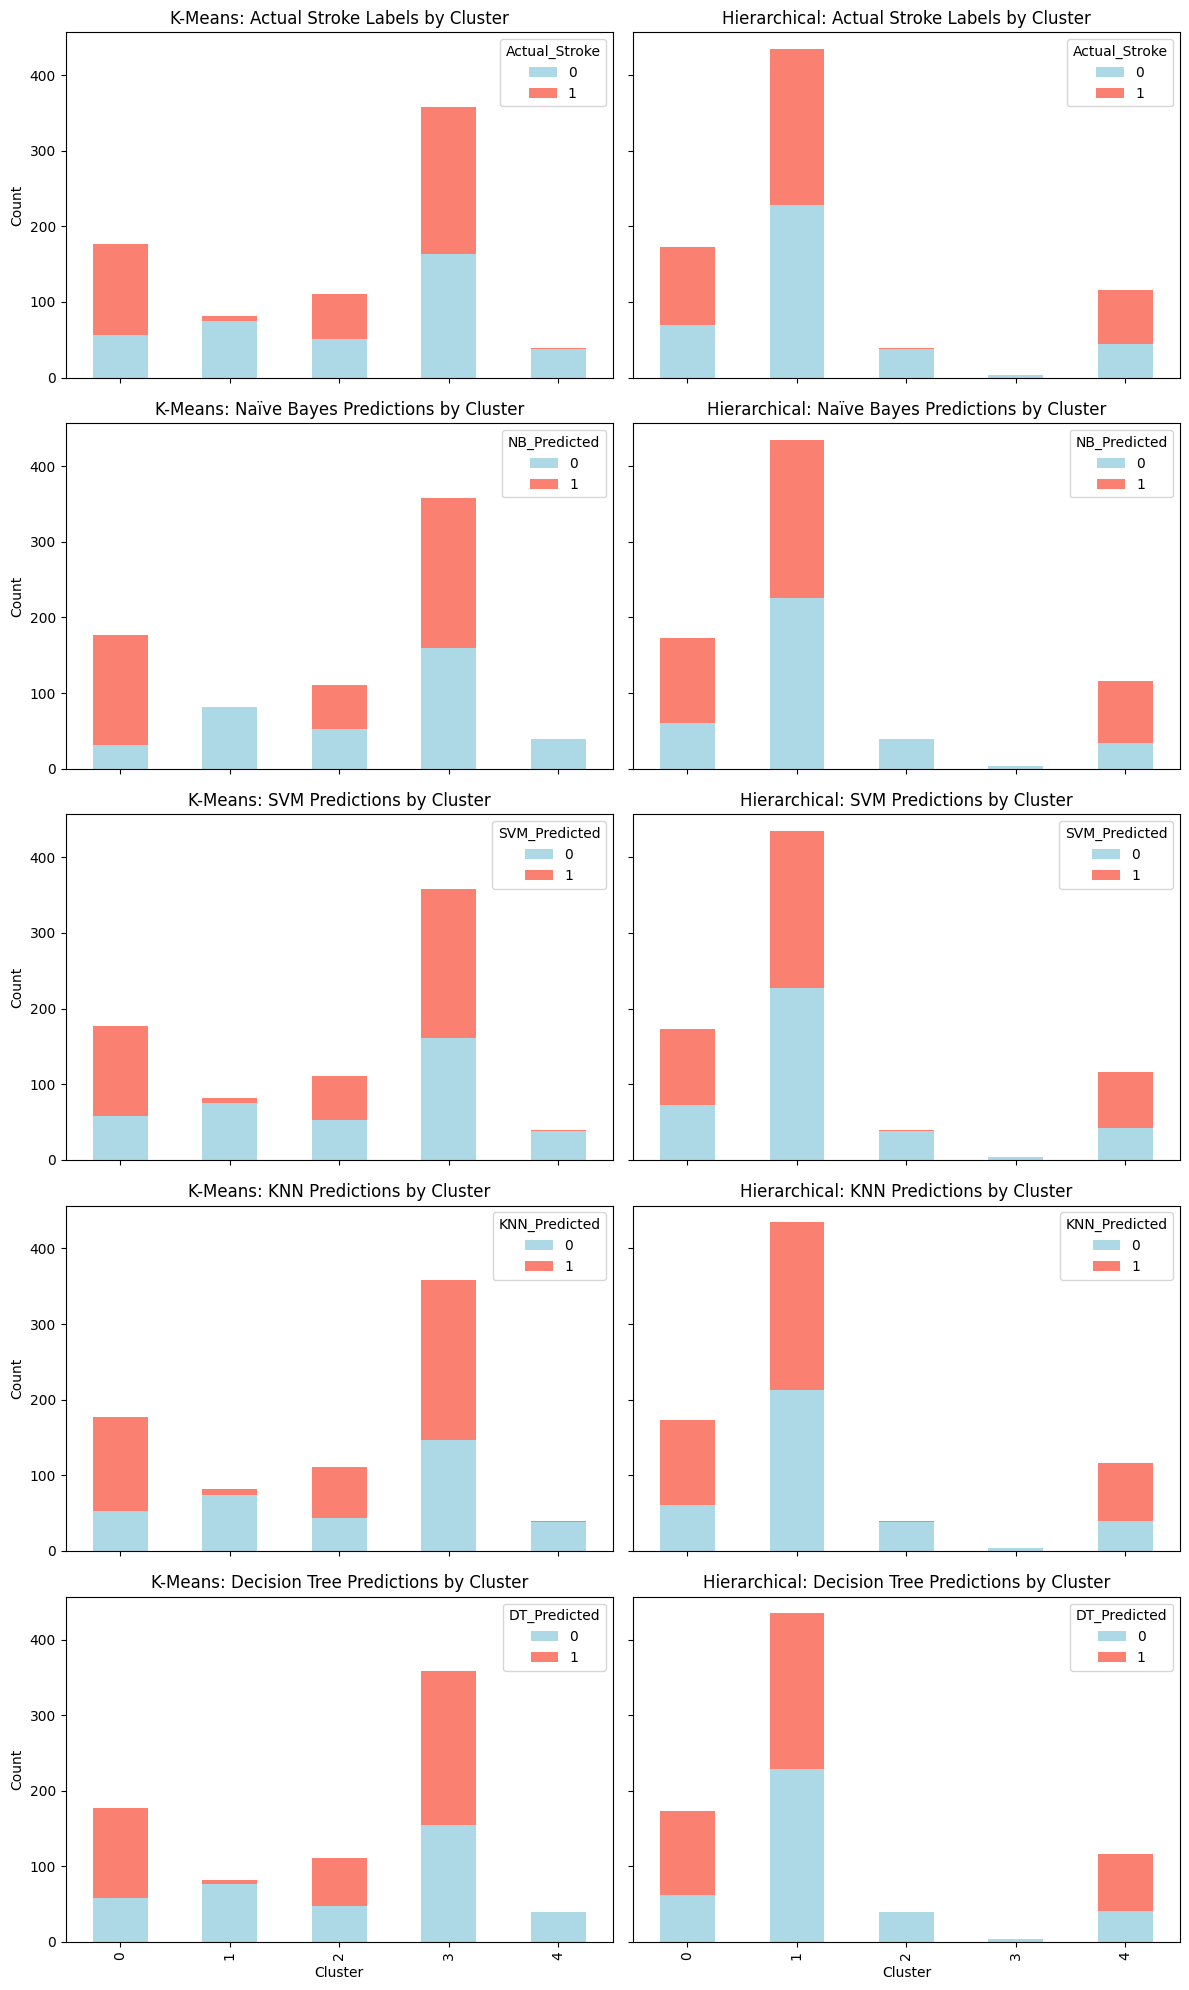

In [ ]:

# Step 5: Visualizations
# Stacked bar plots for K-Means
actual_counts_kmeans = test_comparison_df_kmeans.groupby('Cluster')['Actual_Stroke'].value_counts().unstack().fillna(0)
nb_counts_kmeans = test_comparison_df_kmeans.groupby('Cluster')['NB_Predicted'].value_counts().unstack().fillna(0)
svm_counts_kmeans = test_comparison_df_kmeans.groupby('Cluster')['SVM_Predicted'].value_counts().unstack().fillna(0)
knn_counts_kmeans = test_comparison_df_kmeans.groupby('Cluster')['KNN_Predicted'].value_counts().unstack().fillna(0)
dt_counts_kmeans = test_comparison_df_kmeans.groupby('Cluster')['DT_Predicted'].value_counts().unstack().fillna(0)

# Stacked bar plots for Hierarchical
actual_counts_hierarchical = test_comparison_df_hierarchical.groupby('Cluster')['Actual_Stroke'].value_counts().unstack().fillna(0)
nb_counts_hierarchical = test_comparison_df_hierarchical.groupby('Cluster')['NB_Predicted'].value_counts().unstack().fillna(0)
svm_counts_hierarchical = test_comparison_df_hierarchical.groupby('Cluster')['SVM_Predicted'].value_counts().unstack().fillna(0)
knn_counts_hierarchical = test_comparison_df_hierarchical.groupby('Cluster')['KNN_Predicted'].value_counts().unstack().fillna(0)
dt_counts_hierarchical = test_comparison_df_hierarchical.groupby('Cluster')['DT_Predicted'].value_counts().unstack().fillna(0)

# Create subplots for both K-Means and Hierarchical
fig, axes = plt.subplots(5, 2, figsize=(12, 20), sharex=True, sharey=True)

# K-Means plots
actual_counts_kmeans.plot(kind='bar', stacked=True, ax=axes[0, 0], color=['lightblue', 'salmon'])
axes[0, 0].set_title('K-Means: Actual Stroke Labels by Cluster')
axes[0, 0].set_ylabel('Count')

nb_counts_kmeans.plot(kind='bar', stacked=True, ax=axes[1, 0], color=['lightblue', 'salmon'])
axes[1, 0].set_title('K-Means: Naïve Bayes Predictions by Cluster')
axes[1, 0].set_ylabel('Count')

svm_counts_kmeans.plot(kind='bar', stacked=True, ax=axes[2, 0], color=['lightblue', 'salmon'])
axes[2, 0].set_title('K-Means: SVM Predictions by Cluster')
axes[2, 0].set_ylabel('Count')

knn_counts_kmeans.plot(kind='bar', stacked=True, ax=axes[3, 0], color=['lightblue', 'salmon'])
axes[3, 0].set_title('K-Means: KNN Predictions by Cluster')
axes[3, 0].set_ylabel('Count')

dt_counts_kmeans.plot(kind='bar', stacked=True, ax=axes[4, 0], color=['lightblue', 'salmon'])
axes[4, 0].set_title('K-Means: Decision Tree Predictions by Cluster')
axes[4, 0].set_ylabel('Count')
axes[4, 0].set_xlabel('Cluster')

# Hierarchical plots
actual_counts_hierarchical.plot(kind='bar', stacked=True, ax=axes[0, 1], color=['lightblue', 'salmon'])
axes[0, 1].set_title('Hierarchical: Actual Stroke Labels by Cluster')

nb_counts_hierarchical.plot(kind='bar', stacked=True, ax=axes[1, 1], color=['lightblue', 'salmon'])
axes[1, 1].set_title('Hierarchical: Naïve Bayes Predictions by Cluster')

svm_counts_hierarchical.plot(kind='bar', stacked=True, ax=axes[2, 1], color=['lightblue', 'salmon'])
axes[2, 1].set_title('Hierarchical: SVM Predictions by Cluster')

knn_counts_hierarchical.plot(kind='bar', stacked=True, ax=axes[3, 1], color=['lightblue', 'salmon'])
axes[3, 1].set_title('Hierarchical: KNN Predictions by Cluster')

dt_counts_hierarchical.plot(kind='bar', stacked=True, ax=axes[4, 1], color=['lightblue', 'salmon'])
axes[4, 1].set_title('Hierarchical: Decision Tree Predictions by Cluster')
axes[4, 1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()


In [ ]:
# Step 6: Evaluate classifier performance by cluster for K-Means
print("\nK-Means Cluster Performance")
print("==========================")
for cluster in test_comparison_df_kmeans['Cluster'].unique():
    cluster_data = test_comparison_df_kmeans[test_comparison_df_kmeans['Cluster'] == cluster]
    print(f"\nTest Set Cluster {cluster} (K-Means):")
    print("Actual Stroke Distribution:", cluster_data['Actual_Stroke'].value_counts(normalize=True) * 100)
    print("NB Accuracy:", accuracy_score(cluster_data['Actual_Stroke'], cluster_data['NB_Predicted']))
    print("NB F1-Score:", f1_score(cluster_data['Actual_Stroke'], cluster_data['NB_Predicted']))
    print("SVM Accuracy:", accuracy_score(cluster_data['Actual_Stroke'], cluster_data['SVM_Predicted']))
    print("SVM F1-Score:", f1_score(cluster_data['Actual_Stroke'], cluster_data['SVM_Predicted']))
    print("KNN Accuracy:", accuracy_score(cluster_data['Actual_Stroke'], cluster_data['KNN_Predicted']))
    print("KNN F1-Score:", f1_score(cluster_data['Actual_Stroke'], cluster_data['KNN_Predicted']))
    print("DT Accuracy:", accuracy_score(cluster_data['Actual_Stroke'], cluster_data['DT_Predicted']))
    print("DT F1-Score:", f1_score(cluster_data['Actual_Stroke'], cluster_data['DT_Predicted']))

# Step 7: Evaluate classifier performance by cluster for Hierarchical
print("\nHierarchical Cluster Performance")
print("==============================")
for cluster in test_comparison_df_hierarchical['Cluster'].unique():
    cluster_data = test_comparison_df_hierarchical[test_comparison_df_hierarchical['Cluster'] == cluster]
    print(f"\nTest Set Cluster {cluster} (Hierarchical):")
    print("Actual Stroke Distribution:", cluster_data['Actual_Stroke'].value_counts(normalize=True) * 100)
    print("NB Accuracy:", accuracy_score(cluster_data['Actual_Stroke'], cluster_data['NB_Predicted']))
    print("NB F1-Score:", f1_score(cluster_data['Actual_Stroke'], cluster_data['NB_Predicted']))
    print("SVM Accuracy:", accuracy_score(cluster_data['Actual_Stroke'], cluster_data['SVM_Predicted']))
    print("SVM F1-Score:", f1_score(cluster_data['Actual_Stroke'], cluster_data['SVM_Predicted']))
    print("KNN Accuracy:", accuracy_score(cluster_data['Actual_Stroke'], cluster_data['KNN_Predicted']))
    print("KNN F1-Score:", f1_score(cluster_data['Actual_Stroke'], cluster_data['KNN_Predicted']))
    print("DT Accuracy:", accuracy_score(cluster_data['Actual_Stroke'], cluster_data['DT_Predicted']))
    print("DT F1-Score:", f1_score(cluster_data['Actual_Stroke'], cluster_data['DT_Predicted']))


K-Means Cluster Performance

Test Set Cluster 2 (K-Means):
Actual Stroke Distribution: Actual_Stroke
0    53.164557
1    46.835443
Name: proportion, dtype: float64
NB Accuracy: 0.7518987341772152
NB F1-Score: 0.7421052631578947
SVM Accuracy: 0.959493670886076
SVM F1-Score: 0.9578947368421052
KNN Accuracy: 0.9468354430379747
KNN F1-Score: 0.9451697127937336
DT Accuracy: 0.9291139240506329
DT F1-Score: 0.925531914893617

Test Set Cluster 4 (K-Means):
Actual Stroke Distribution: Actual_Stroke
1    79.439252
0    20.560748
Name: proportion, dtype: float64
NB Accuracy: 0.794392523364486
NB F1-Score: 0.8854166666666666
SVM Accuracy: 0.9906542056074766
SVM F1-Score: 0.9941520467836257
KNN Accuracy: 0.9439252336448598
KNN F1-Score: 0.9659090909090909
DT Accuracy: 0.9345794392523364
DT F1-Score: 0.9590643274853801

Test Set Cluster 0 (K-Means):
Actual Stroke Distribution: Actual_Stroke
0    100.0
Name: proportion, dtype: float64
NB Accuracy: 1.0
NB F1-Score: 0.0
SVM Accuracy: 1.0
SVM F1-Score: